<a href="https://colab.research.google.com/github/Kat-nesh/Redefining-maize-UAI/blob/main/Model_Training_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data:
Raw: '/data/raw.csv'
Processed: '/data/processed.csv'

## Prerequisites

- Import earth engine and geemap



In [56]:
from IPython.core.magics.execution import Restart
try:
  import geemap
  import ee
  import geopandas
except Exception as e:
  !pip install geopandas
  !pip install geemap
  Restart()
finally:
  import geemap
  import ee

In [57]:
#geemap.update_package()

**Not Required to run**

In [58]:

# try:
#   ee.Initialize()
# except Exception as e:
#   ee.Authenticate()
#   ee.Initialize(project='ee-maizeyield')

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from geemap import ml
from sklearn import ensemble
from geemap import ml
from sklearn import ensemble
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_score
plt.rcParams.update({'figure.figsize': (12.0,8.0)})
plt.rcParams.update({'font.size' : 14})
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# 1.Predictor Variables Preprocessing

Steps include:
1. Exploratory investigations
2. Data cleaning  (removing NAs)

In [131]:
# Loading training data
# df = pd.read_csv('/content/drive/MyDrive/All_Predictors/reprocessed-indices_with_FinalJoined.csv')
df = pd.read_csv('/data/raw.csv')
df.describe(include='all')
df.to_csv('raw.csv', index=False)



In [61]:
df.columns

Index(['key', 'COUNTY', 'Year', 'Yield', 'blue', 'green', 'red', 'nir',
       'swir1', 'swir2', 'ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi',
       'msavi', 'gci', 'gli', 'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2',
       'rdvi', 'gvi', 'ndii', 'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi',
       'pssra', 'dvi', 'era5d_prec', 'era5_wind', 'era5m_wind', 'era5m_prec',
       'era5_mean_temp', 'era5_min_temp', 'era5_max_temp', 'era5m_mean_temp',
       'era5m_min_temp', 'era5m_max_temp', 'chirpsd_prec', 'chirpsm_prec',
       'AREA', 'temp_MIN', 'temp_MAX', 'RANGE', 'temp_MEAN', 'temp_STD',
       'temp_SUM', 'fpar', 'm_lai', 'm_gndvi', 'm_ndvi', 'm_ndmi', 'gpp',
       'npp', 'Tmst_AREA', 'Tmst_MIN', 'Tmst_MAX', 'Tmst_RANGE', 'Tmst_MEAN',
       'Tmst_STD', 'Tmst_SUM', 'Yield2', 'mod_lst', 'ggcp10', 'final_Yld',
       'JoinedYld'],
      dtype='object')

In [62]:
data = df[df['Year'].between(2010, 2020)]

1.1. Data cleaning (removing NAs and unneded columns)

In [63]:
# FIND & REMOVE NAs
data.isna().sum()
data[data.isna().any(axis=1)]


,key,COUNTY,Year,Yield,blue,green,red,nir,swir1,swir2,...,Tmst_MAX,Tmst_RANGE,Tmst_MEAN,Tmst_STD,Tmst_SUM,Yield2,mod_lst,ggcp10,final_Yld,JoinedYld
0,2010_BARINGO,BARINGO,2010,2.446140,13466.61207,13579.56526,14037.68821,18064.05894,16139.75614,12884.67164,...,223.633331,124.183334,165.862906,26.893221,27201.516640,NaN,14969.65208,1.202656,NaN,2.446140
1,2010_BOMET,BOMET,2010,2.534296,9273.87625,10270.83435,10170.83956,18802.30141,15480.64139,11918.84365,...,202.533325,100.216660,133.915805,20.536819,7767.116714,NaN,14964.35159,4.933519,NaN,2.534296
2,2010_BUNGOMA,BUNGOMA,2010,2.616617,17854.93803,17050.62684,17695.21449,20411.25788,17761.26924,13750.84017,...,196.516663,49.683334,168.121518,12.796983,22528.283370,NaN,14963.83447,3.188185,NaN,2.616617
3,2010_BUSIA,BUSIA,2010,3.114873,20577.71760,19430.25052,20177.74615,21080.29136,19366.22202,14691.73165,...,199.400009,71.033340,168.821512,15.097006,14518.650010,NaN,15079.52976,3.514851,NaN,3.114873
4,2010_ELGEYO-MARAKWET,ELGEYO-MARAKWET,2010,3.114873,17064.11439,16820.43171,17288.38226,20857.02672,18154.90550,13714.83444,...,231.000000,91.683334,185.939693,19.557142,14131.416660,NaN,14751.63249,0.773917,NaN,3.114873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,2022_TRANS NZOIA,TRANS NZOIA,2022,NaN,13280.04653,14416.41360,14387.53534,21319.92801,16868.91258,14168.32388,...,158.500000,77.099998,118.168142,16.064765,13353.000050,NaN,14960.55193,NaN,3.573576,3.573576
539,2022_TURKANA,TURKANA,2022,NaN,11081.26523,12701.43966,13370.20804,19215.70020,16788.13028,14694.39021,...,0.600000,0.000000,0.600000,0.000000,0.600000,NaN,15787.10061,NaN,0.132482,0.132482
540,2022_UASIN GISHU,UASIN GISHU,2022,NaN,15924.23649,16793.24959,16900.12788,22514.50984,18307.82148,15405.13307,...,155.100006,79.300003,104.667683,17.023466,17165.499950,NaN,14891.12617,NaN,3.500000,3.500000
541,2022_VIHIGA,VIHIGA,2022,NaN,10899.80867,12243.34086,12113.23125,20331.52333,15659.46462,12856.96251,...,220.199997,53.500000,189.724137,12.211233,5501.999985,NaN,14929.61504,NaN,0.969130,0.969130


In [64]:
train = data.drop(columns = ['AREA','key','RANGE','COUNTY'])
train.describe()

,Year,Yield,blue,green,red,nir,swir1,swir2,ndvi,savi,...,Tmst_MAX,Tmst_RANGE,Tmst_MEAN,Tmst_STD,Tmst_SUM,Yield2,mod_lst,ggcp10,final_Yld,JoinedYld
count,543.000000,378.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,...,543.000000,543.000000,543.000000,543.000000,543.000000,418.000000,543.000000,461.000000,459.000000,543.000000
mean,2015.972376,1.565389,15315.570308,15989.082517,16274.957286,21294.584040,18042.908219,14592.711695,0.154078,0.231113,...,140.392954,81.130388,97.503739,18.849126,9925.435195,1.546818,15055.470270,2.121945,1.492754,1.518524
std,3.736374,0.935836,5154.868047,4523.001854,4851.937539,2438.465086,2536.106998,1724.637864,0.089198,0.133795,...,111.594427,68.597981,85.209268,15.670354,15808.970276,0.943439,200.684338,1.175216,0.931341,0.934726
min,2010.000000,0.073561,9143.756000,10170.156960,10070.378840,15201.186490,14264.674560,11113.324250,-0.125322,-0.187981,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.070000,14668.905120,0.015409,0.005076,0.005076
25%,2013.000000,0.897919,11578.464515,12675.343325,12820.878185,19524.226175,16162.782465,13246.450865,0.106695,0.160040,...,35.099998,28.900000,8.862897,7.049760,489.049999,0.880000,14921.106945,1.364666,0.841769,0.864907
50%,2016.000000,1.368918,14092.756490,14843.976210,15048.983630,20923.751730,17376.882110,14282.928530,0.164785,0.247174,...,139.899994,66.800003,88.027273,15.812626,5830.299988,1.335000,15028.829250,2.199110,1.287565,1.316058
75%,2019.000000,2.156738,17638.990315,18022.087680,18455.477785,22862.531525,19527.345580,15960.990505,0.218186,0.327274,...,211.250000,118.699997,157.332478,26.534196,14176.408300,2.075000,15156.443275,2.957867,1.933931,2.013530
max,2022.000000,5.090926,40761.130780,39770.558290,40505.574260,32026.710420,32362.643070,18865.725980,0.310899,0.466341,...,600.500000,443.000000,389.870093,93.047153,264718.399900,5.090000,15878.890780,5.522266,5.224867,5.224867


1.2. Exploratory investigations (statistics)

In [65]:
export = train.drop(columns = ['Year', 'Yield', 'blue', 'green', 'red', 'nir', 'swir1','swir2','Tmst_STD', 'Tmst_SUM', 'Yield2',  'final_Yld','Tmst_RANGE',
                         'Tmst_AREA','temp_STD','temp_SUM'])
export

,ndvi,savi,evi,gndvi,ndmi,nsi,msavi,gci,gli,sipi,...,m_ndvi,m_ndmi,gpp,npp,Tmst_MIN,Tmst_MAX,Tmst_MEAN,mod_lst,ggcp10,JoinedYld
0,0.138529,0.207790,0.598913,0.153983,0.057941,-84.877679,0.230592,0.389278,-0.003476,0.947154,...,0.570164,0.144127,379.780783,12825.630780,99.449997,223.633331,165.862906,14969.65208,1.202656,2.446140
1,0.298718,0.448069,2.140336,0.294082,0.096982,-38.408083,0.459042,0.836417,0.027874,1.103924,...,0.708306,0.208101,542.836743,16691.331520,102.316666,202.533325,133.915805,14964.35159,4.933519,2.534296
2,0.090397,0.135593,0.774805,0.107608,0.071805,-27.725545,0.146563,0.273572,-0.018398,1.130202,...,0.662395,0.166180,410.496829,13195.145850,146.833328,196.516663,168.121518,14963.83447,3.188185,2.616617
3,0.036797,0.055195,3.977414,0.055864,0.046039,-49.537970,0.053365,0.143195,-0.024322,1.027753,...,0.660390,0.144746,364.949335,10958.859400,128.366669,199.400009,168.821512,15079.52976,3.514851,3.114873
4,0.111312,0.166966,-0.643741,0.123733,0.072927,-91.081551,0.184736,0.310478,-0.008146,1.048769,...,0.665544,0.189264,446.234790,15411.262590,139.316666,231.000000,185.939693,14751.63249,0.773917,3.114873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,0.198264,0.297391,3.544773,0.197352,0.116345,-65.436573,0.328914,0.498328,0.021913,1.158857,...,0.667761,0.199905,488.261814,14027.767370,81.400002,158.500000,118.168142,14960.55193,NaN,3.573576
539,0.179538,0.269303,1.003145,0.203841,0.068051,-35.550686,0.301227,0.517676,0.019410,1.457382,...,0.268741,-0.021080,91.093305,473.207627,0.600000,0.600000,0.600000,15787.10061,NaN,0.132482
540,0.146907,0.220358,2.852756,0.149945,0.102518,-78.516359,0.253938,0.358295,0.012688,1.172599,...,0.629995,0.155621,434.038210,12336.601220,75.800003,155.100006,104.667683,14891.12617,NaN,3.500000
541,0.256969,0.385447,1.911246,0.251538,0.130018,-57.157424,0.406922,0.679823,0.032473,1.148572,...,0.704768,0.231280,458.847744,12619.352950,166.699997,220.199997,189.724137,14929.61504,NaN,0.969130


In [66]:
# export.to_csv('processed.csv', index=False)


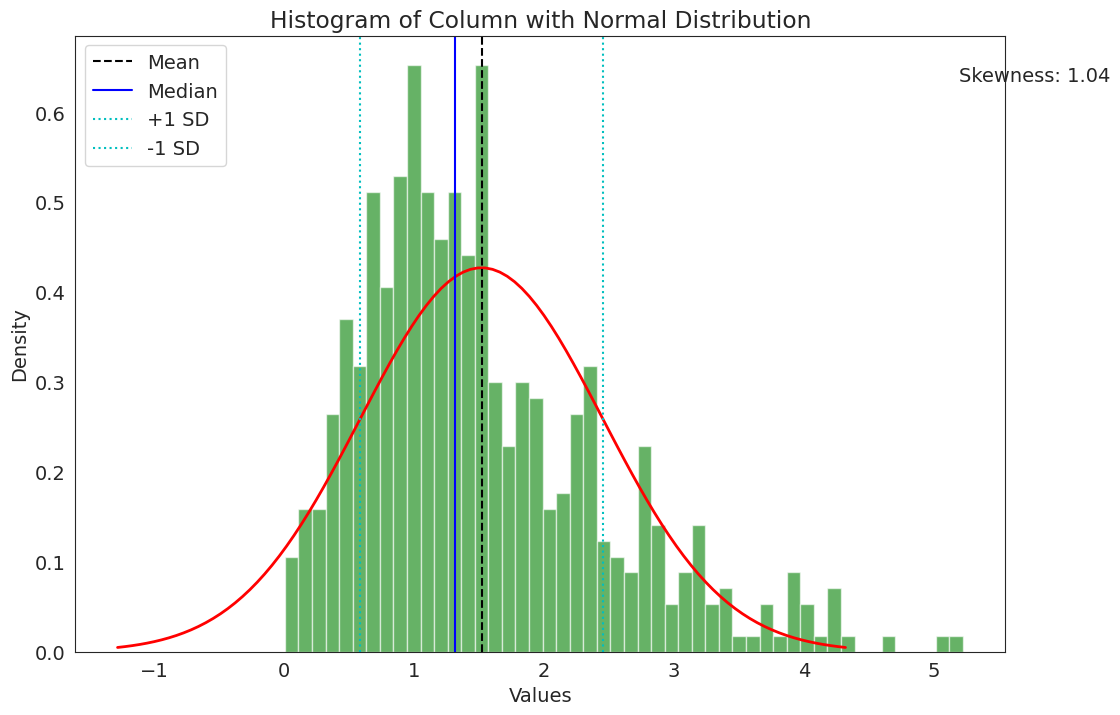

In [67]:
# Investigate Yield Data
column = data['JoinedYld']

# Calculate the mean, median, and standard deviation
mean = column.mean()
median = column.median()
std = column.std()

# Calculate the skewness
skewness = column.skew()

# Fit a normal distribution to the data
mu, std_fit = stats.norm.fit(column)

# Plot the histogram
n, bins, patches = plt.hist(column, bins=50, density=True, alpha=0.6, color='g')

# Plot the normal distribution
x = np.linspace(mu - 3*std_fit, mu + 3*std_fit, 100)
y = stats.norm.pdf(x, mu, std_fit)
plt.plot(x, y, 'r', linewidth=2)

# Add mean, median, and standard deviation lines
plt.axvline(mean, color='k', linestyle='--', label='Mean')
plt.axvline(median, color='b', linestyle='-', label='Median')
plt.axvline(mean + std, color='c', linestyle=':', label='+1 SD')
plt.axvline(mean - std, color='c', linestyle=':', label='-1 SD')

# Add a title and labels to the x and y axes
plt.title('Histogram of Column with Normal Distribution')
plt.xlabel('Values')
plt.ylabel('Density')

# Add skewness text
plt.text(0.95, 0.95, 'Skewness: {:.2f}'.format(skewness),
         horizontalalignment='left',
         verticalalignment='top',
         transform=plt.gca().transAxes)

# # Add a legend
plt.legend()

# Show the plot
plt.show()



**Train and Test Splits on the dataset**

In [68]:
features = train
features.columns, features.shape

(Index(['Year', 'Yield', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2',
        'ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi', 'msavi', 'gci', 'gli',
        'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2', 'rdvi', 'gvi', 'ndii',
        'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi', 'pssra', 'dvi',
        'era5d_prec', 'era5_wind', 'era5m_wind', 'era5m_prec', 'era5_mean_temp',
        'era5_min_temp', 'era5_max_temp', 'era5m_mean_temp', 'era5m_min_temp',
        'era5m_max_temp', 'chirpsd_prec', 'chirpsm_prec', 'temp_MIN',
        'temp_MAX', 'temp_MEAN', 'temp_STD', 'temp_SUM', 'fpar', 'm_lai',
        'm_gndvi', 'm_ndvi', 'm_ndmi', 'gpp', 'npp', 'Tmst_AREA', 'Tmst_MIN',
        'Tmst_MAX', 'Tmst_RANGE', 'Tmst_MEAN', 'Tmst_STD', 'Tmst_SUM', 'Yield2',
        'mod_lst', 'ggcp10', 'final_Yld', 'JoinedYld'],
       dtype='object'),
 (543, 70))

In [69]:
# TRAIN SPLIT
yld = train['JoinedYld']
yld.shape
pred = train.drop([ 'Year', 'Yield', 'blue', 'green', 'red', 'nir', 'swir1','swir2','Tmst_STD', 'Tmst_SUM', 'Yield2', 'ggcp10', 'final_Yld','Tmst_RANGE',
                         'Tmst_AREA','temp_STD','temp_SUM', 'JoinedYld','temp_MIN',
       'temp_MAX', 'temp_MEAN'], axis=1)

In [70]:
pred.columns

Index(['ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi', 'msavi', 'gci', 'gli',
       'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2', 'rdvi', 'gvi', 'ndii',
       'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi', 'pssra', 'dvi',
       'era5d_prec', 'era5_wind', 'era5m_wind', 'era5m_prec', 'era5_mean_temp',
       'era5_min_temp', 'era5_max_temp', 'era5m_mean_temp', 'era5m_min_temp',
       'era5m_max_temp', 'chirpsd_prec', 'chirpsm_prec', 'fpar', 'm_lai',
       'm_gndvi', 'm_ndvi', 'm_ndmi', 'gpp', 'npp', 'Tmst_MIN', 'Tmst_MAX',
       'Tmst_MEAN', 'mod_lst'],
      dtype='object')

In [71]:
features = pred

# 2.Model Training
1. Feature Selection
2. Model Training
3. Model Testing (Leave One Year Out Cross Validation)
4. Model Evaluation

In [72]:
# RF Regressor & Fit
# create a classifier and fit
n_trees = 200
clf = RandomForestRegressor(n_trees,random_state = 42)
clf.fit(pred,yld)

RandomForestRegressor(n_estimators=200, random_state=42)

In [73]:
feature_name=pred.columns

In [74]:
feature_name

Index(['ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi', 'msavi', 'gci', 'gli',
       'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2', 'rdvi', 'gvi', 'ndii',
       'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi', 'pssra', 'dvi',
       'era5d_prec', 'era5_wind', 'era5m_wind', 'era5m_prec', 'era5_mean_temp',
       'era5_min_temp', 'era5_max_temp', 'era5m_mean_temp', 'era5m_min_temp',
       'era5m_max_temp', 'chirpsd_prec', 'chirpsm_prec', 'fpar', 'm_lai',
       'm_gndvi', 'm_ndvi', 'm_ndmi', 'gpp', 'npp', 'Tmst_MIN', 'Tmst_MAX',
       'Tmst_MEAN', 'mod_lst'],
      dtype='object')



# 3.Feature Selection based on Feature Importance

In [75]:
# Feature Selection
# Feature Importance
clf.feature_importances_

array([0.00162947, 0.00102882, 0.00935664, 0.00203304, 0.00828435,
       0.00993785, 0.00156844, 0.00291348, 0.00998528, 0.01190754,
       0.00271242, 0.00090582, 0.00226207, 0.00274522, 0.00145273,
       0.00183204, 0.00790844, 0.0086787 , 0.00401844, 0.01201193,
       0.00212489, 0.00350331, 0.00726725, 0.02225474, 0.00406375,
       0.00281502, 0.21600125, 0.01247643, 0.0143335 , 0.06281511,
       0.02412886, 0.02835198, 0.02617353, 0.01822164, 0.01962908,
       0.01395764, 0.03758697, 0.02137248, 0.00781985, 0.00637215,
       0.00774181, 0.00629638, 0.00985316, 0.01817643, 0.11507801,
       0.00787739, 0.06042868, 0.06782026, 0.05228569])

In [76]:
clf.n_features_in_

49

In [77]:
feature_importance = pd.DataFrame(clf.feature_importances_,columns =['Importance'])
feature_importance['Features'] = clf.feature_names_in_
feature_importance.sort_values(by=['Importance'], ascending=False)

,Importance,Features
26,0.216001,era5d_prec
44,0.115078,npp
47,0.067820,Tmst_MEAN
29,0.062815,era5m_prec
46,0.060429,Tmst_MAX
48,0.052286,mod_lst
36,0.037587,chirpsd_prec
31,0.028352,era5_min_temp
32,0.026174,era5_max_temp
30,0.024129,era5_mean_temp


In [78]:
sorted_idx = clf.feature_importances_.argsort()
sorted_idx.shape

(49,)

In [79]:
# features = data.columns[:13]
features = pred.columns
features.shape

(49,)

Text(0.5, 1.0, 'Predictors Correlation')

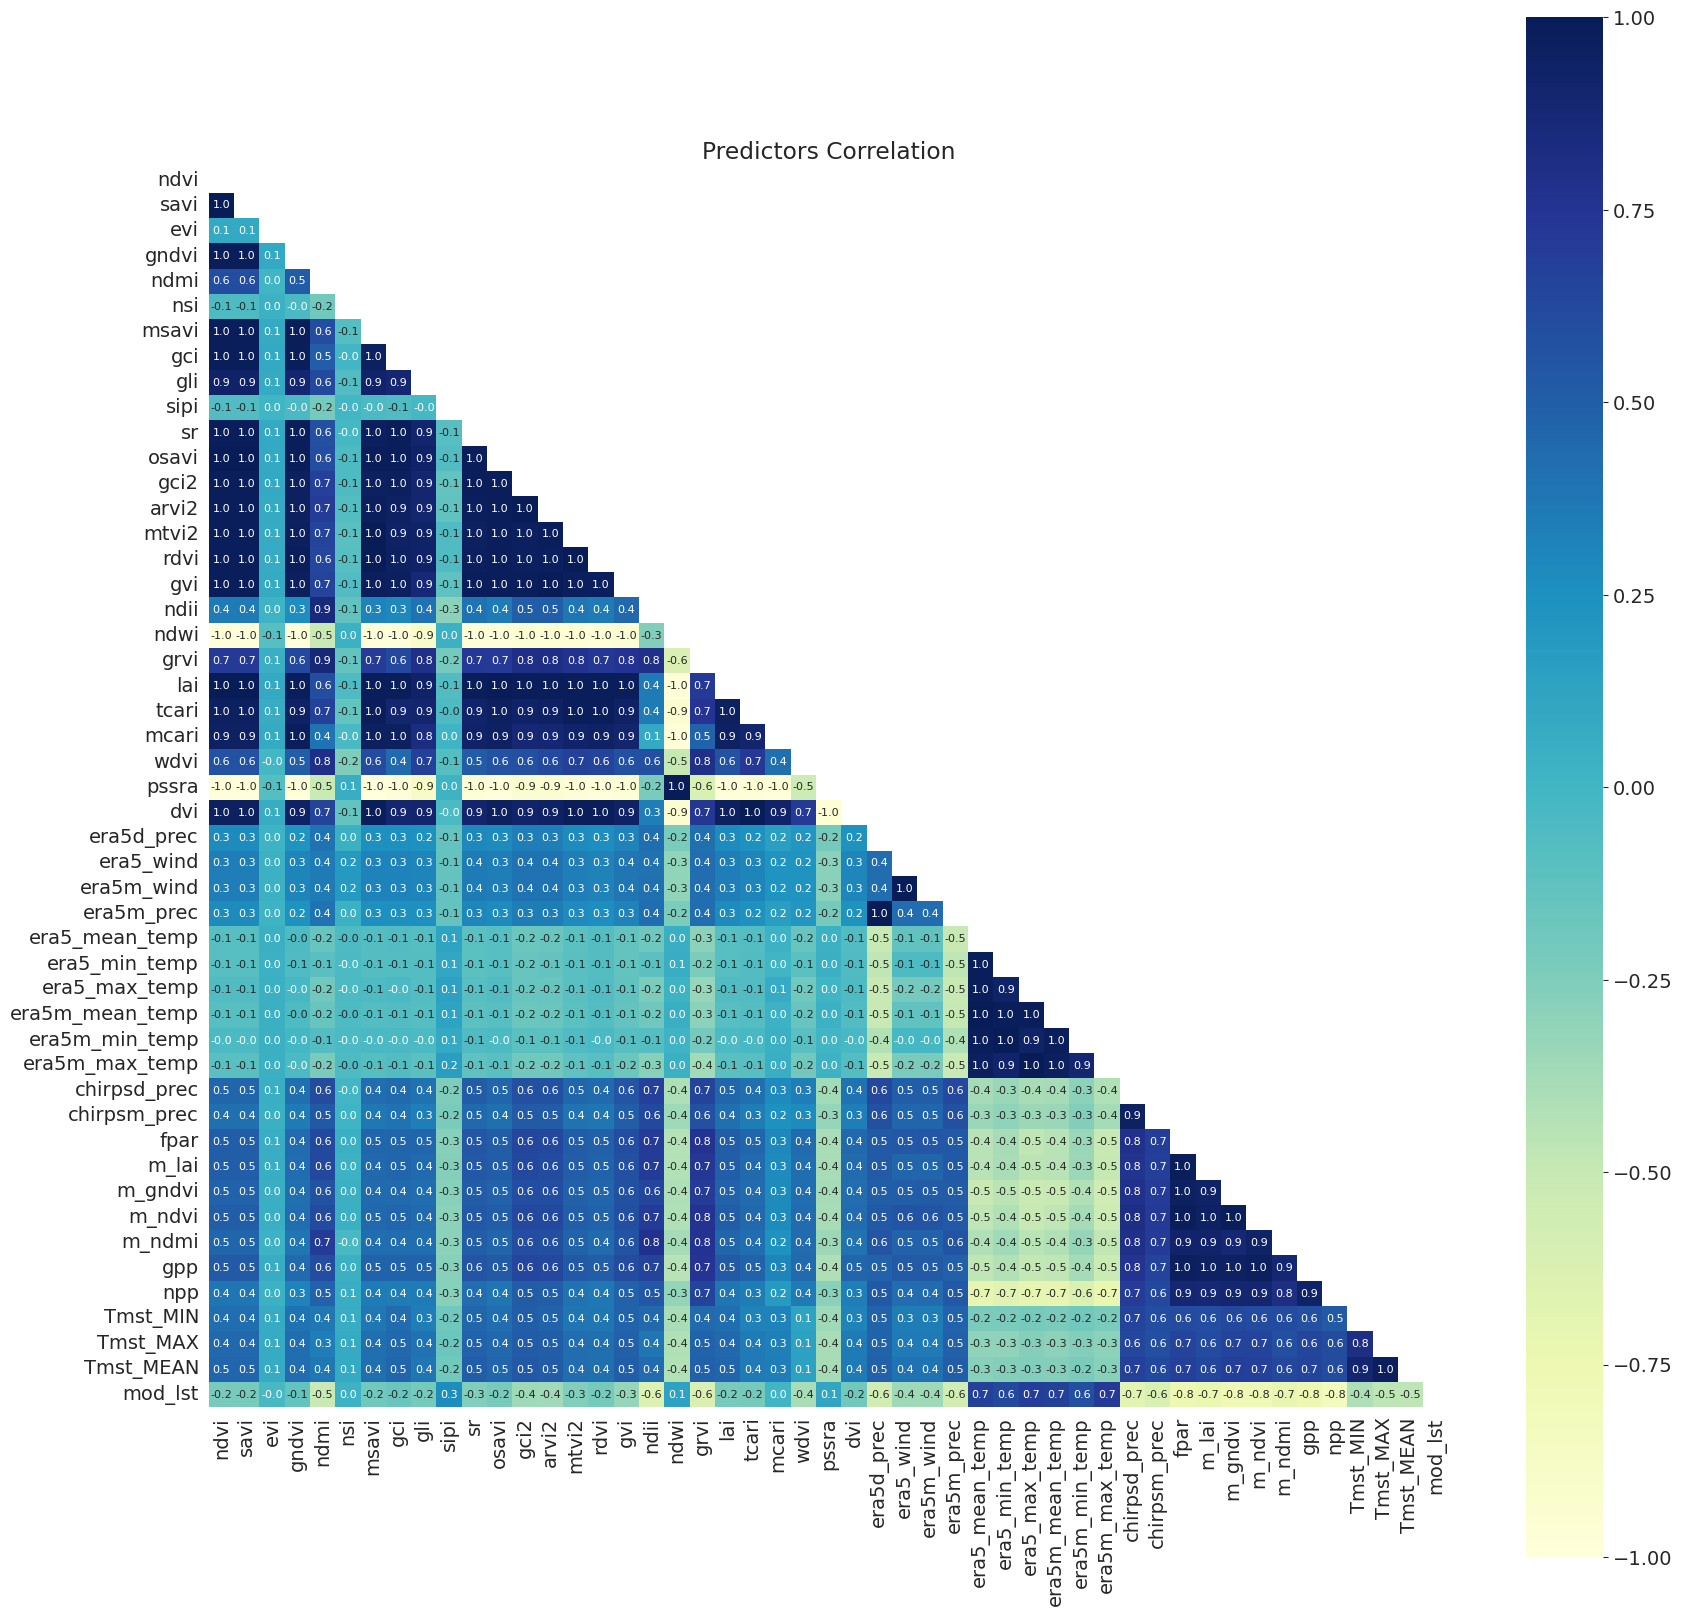

In [80]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(20, 20))

pred_corr = pred.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pred_corr, dtype=bool))

# Plot heatmap
sns.heatmap(pred_corr, cmap="YlGnBu", annot=True, fmt=".1f", ax=ax,annot_kws={"fontsize": 8},mask=mask, square=True)
ax.set_title("Predictors Correlation")


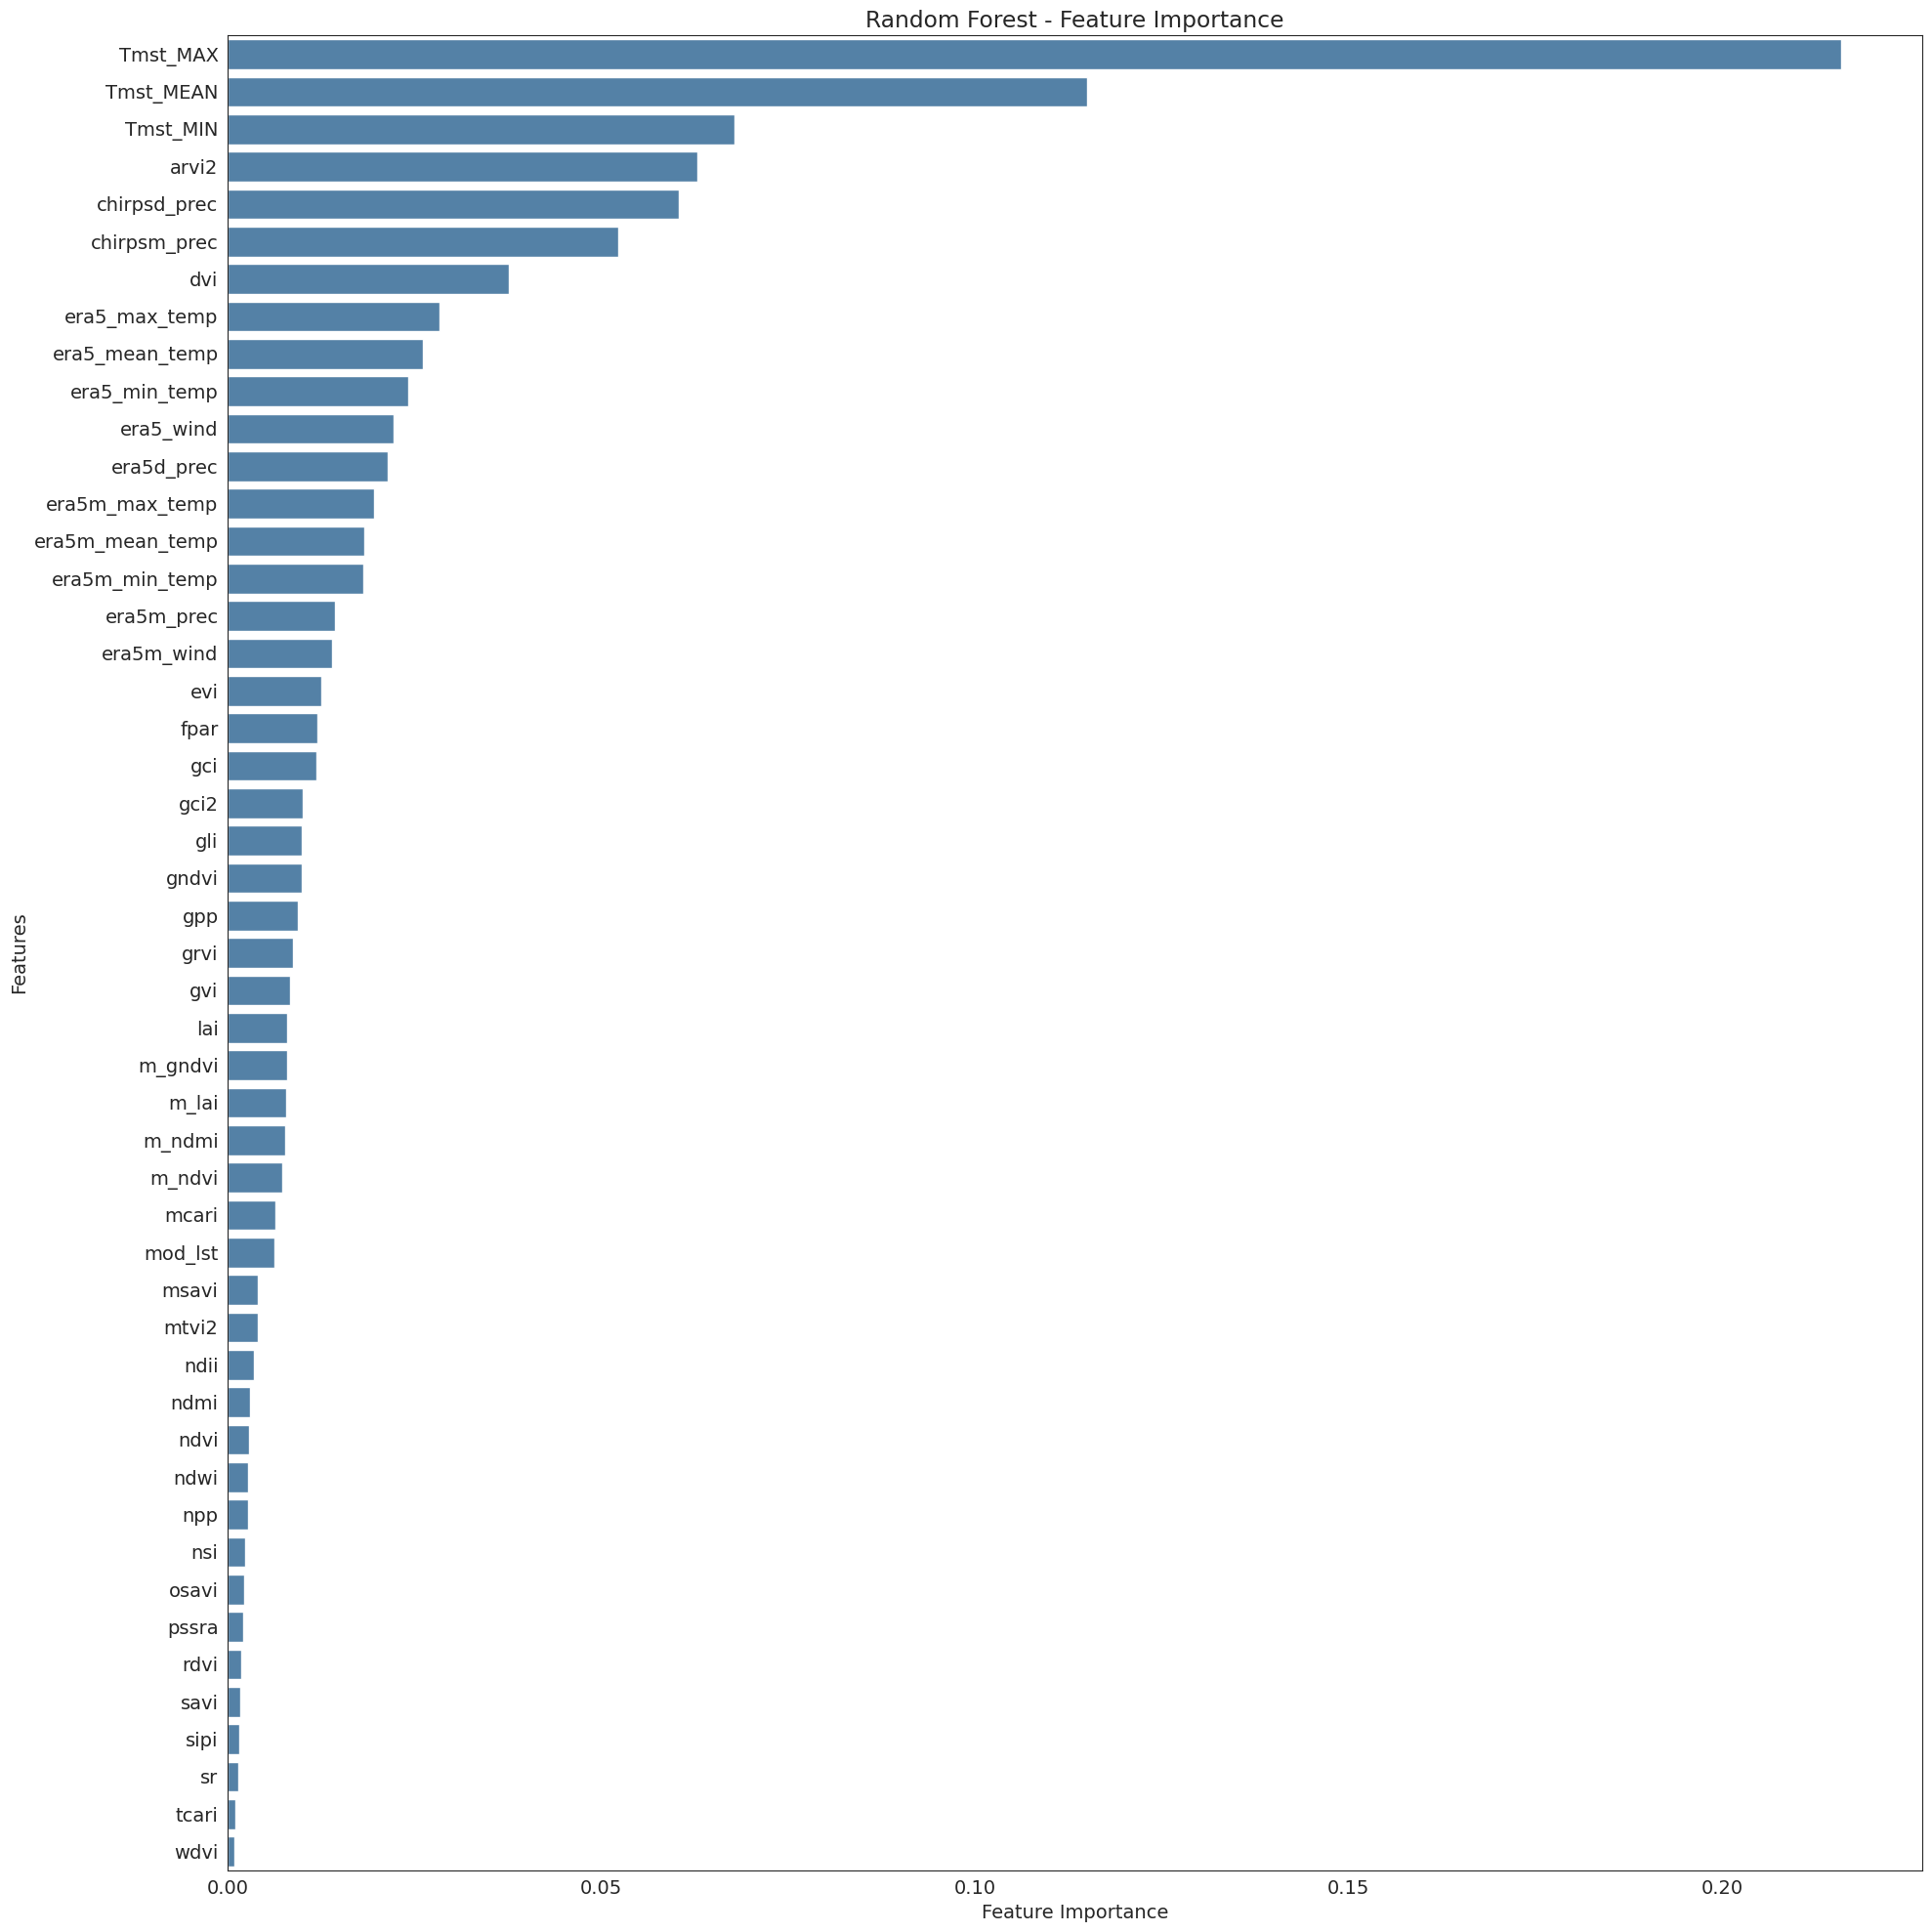

In [81]:
# Plot horizontal bar plot
fig, ax = plt.subplots(figsize=(20, 20))
totals = feature_importance.groupby('Features')["Importance"].mean().sort_values(ascending=False)
sns.barplot(y=totals.index.sort_values(ascending=True), x=totals.values, color="steelblue", ax=ax,orient='h',)
ax.set_title("Random Forest - Feature Importance")
ax.set_xlabel("Feature Importance")

plt.tight_layout()  # Ensures proper spacing between plots
plt.show()

In [82]:
# sns.set(font_scale=0.75)

## 3.1 **Permutation Based Importance**

Randomly shuffles each feature and compute the change in the model’s performance. The features which impact the performance the most are the most important ones

**Pros:**
- overcome drawbacks of default feature importance computed with mean impurity decrease (**Gini importance**)

**Cons:**
- can have problem with highly-correlated features

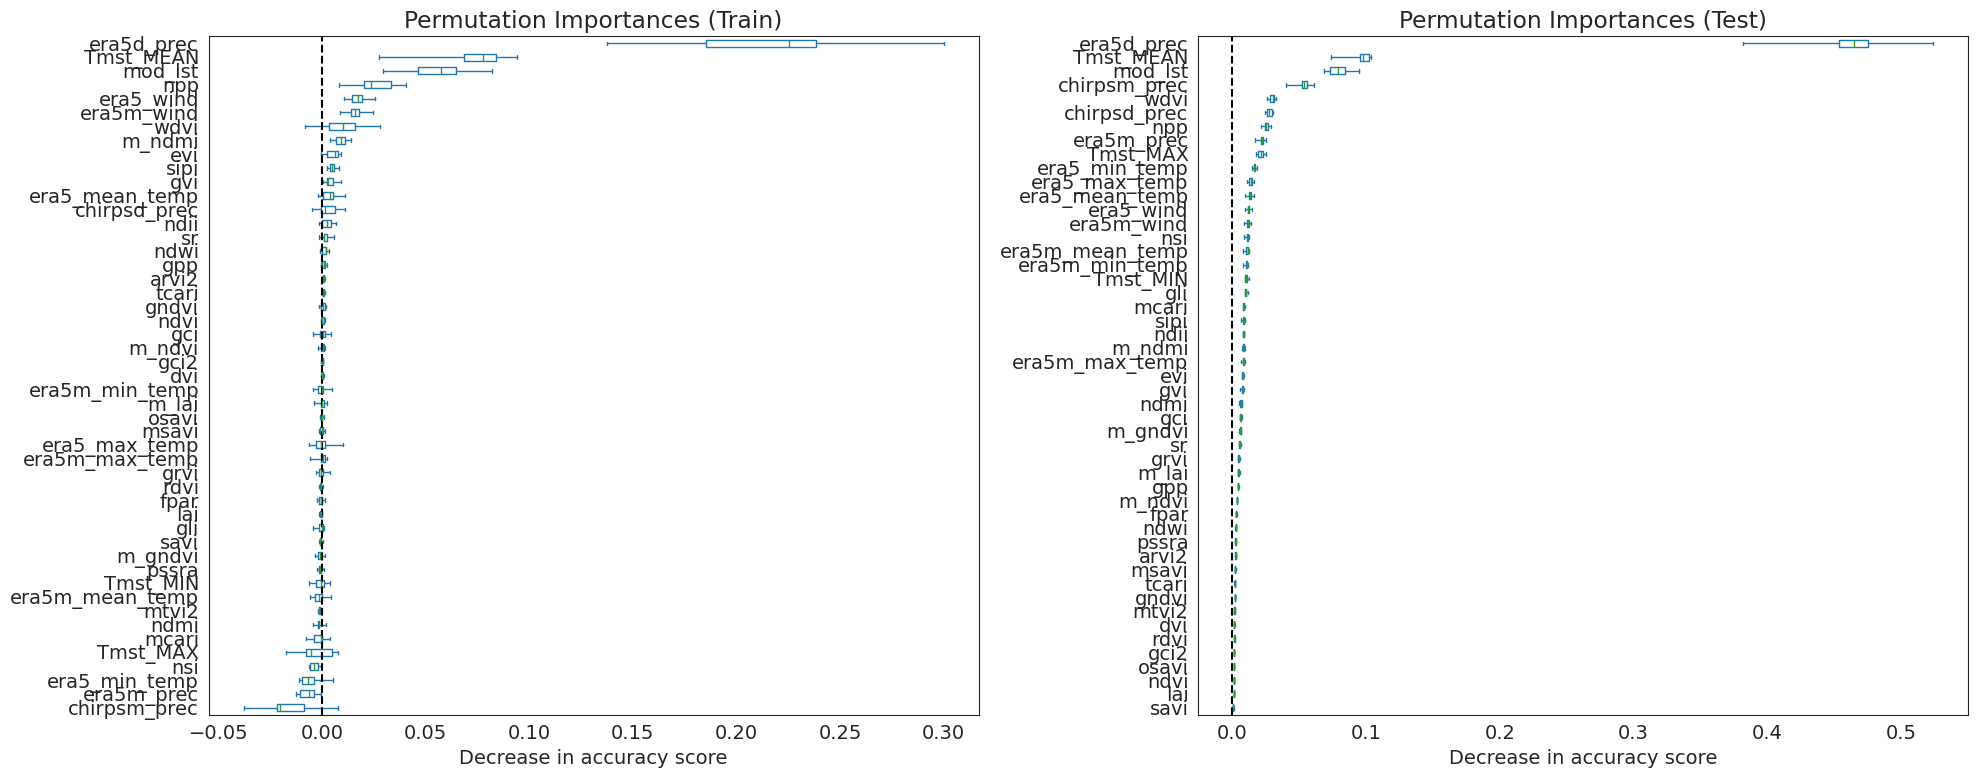

In [83]:
#  Plotting Permutation Importance on train and test data can give a hint if there is an overfitting.
# Features that are likely to be useful and lead to overfitting will have a higher Permutation Importance weight on train data
#  and a lower or almost zero weight on test data.
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

clf = RandomForestRegressor(200,random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(pred,yld, test_size = 0.6, random_state=1)
main_pipeline = clf.fit(X_test,y_test)

pi_train = permutation_importance(
    main_pipeline,
    X_train, y_train,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

sorted_importances_idx = pi_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    pi_train.importances[sorted_importances_idx].T,
    columns=pred.columns[sorted_importances_idx],
)


pi_test = permutation_importance(
    main_pipeline,
    X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

sorted_importances_idx = pi_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    pi_test.importances[sorted_importances_idx].T,
    columns=pred.columns[sorted_importances_idx],
)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

ax1 = importances_train.plot.box(vert=False, whis=10, ax=ax1)
ax1.set_title("Permutation Importances (Train)")
ax1.axvline(x=0, color="k", linestyle="--")
ax1.set_xlabel("Decrease in accuracy score")
ax1.figure.tight_layout()

ax2 = importances_test.plot.box(vert=False, whis=10, ax=ax2)
ax2.set_title("Permutation Importances (Test)")
ax2.axvline(x=0, color="k", linestyle="--")
ax2.set_xlabel("Decrease in accuracy score")
ax2.figure.tight_layout()

In [84]:
# Calculate mean importances
train_importances = importances_train.mean().reset_index()
train_importances.columns = ['predictor', 'train_importance']

test_importances = importances_test.mean().reset_index()
test_importances.columns = ['predictor', 'test_importance']

# Merge DataFrames
final_importances = pd.merge(train_importances, test_importances, on='predictor')
final_importances[['predictor','test_importance']]

,predictor,test_importance
0,chirpsm_prec,0.053040
1,era5m_prec,0.021785
2,era5_min_temp,0.016463
3,nsi,0.011161
4,Tmst_MAX,0.021233
5,mcari,0.008618
6,ndmi,0.006368
7,mtvi2,0.001554
8,era5m_mean_temp,0.010901
9,Tmst_MIN,0.010495


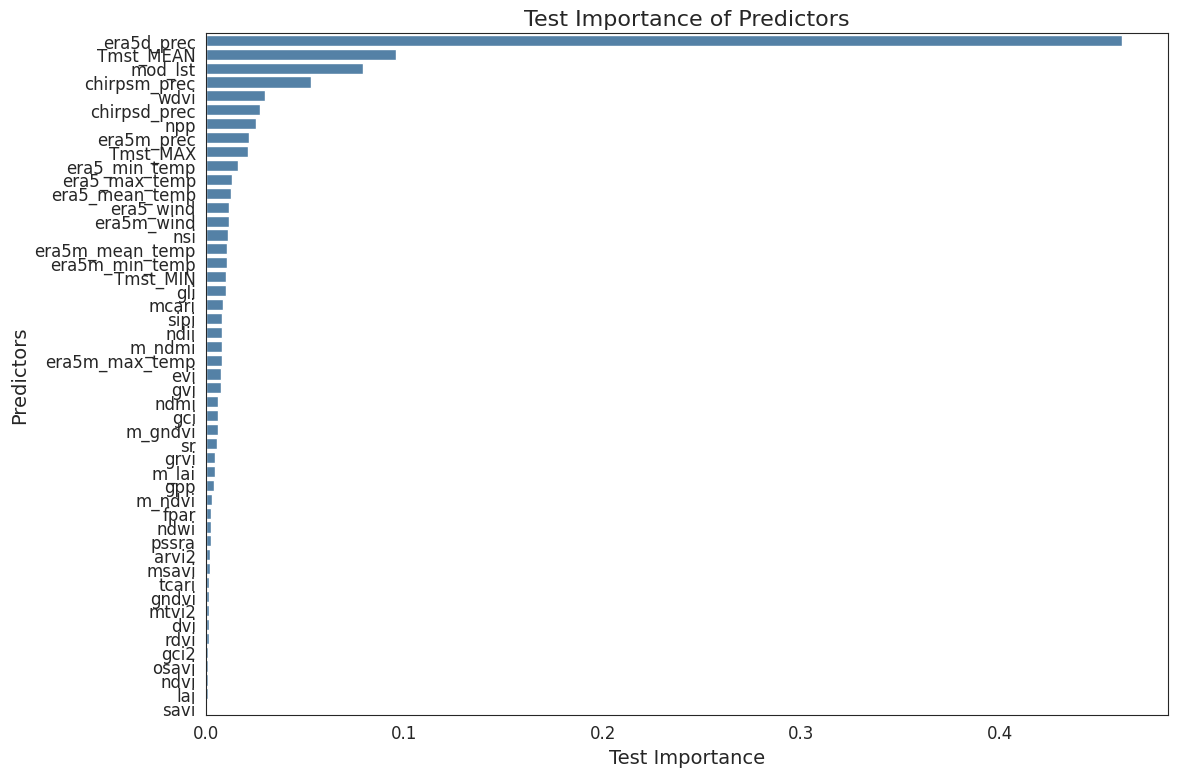

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'final_importances' DataFrame is already created

# Sort the DataFrame by test importance in descending order
final_importances = final_importances.sort_values(by=['test_importance'], ascending=False)

# Create the bar plot using Seaborn
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
sns.barplot(x='test_importance', y='predictor', data=final_importances, color='steelblue')

# Customize the plot
plt.title('Test Importance of Predictors', fontsize=16)
plt.xlabel('Test Importance', fontsize=14)
plt.ylabel('Predictors', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

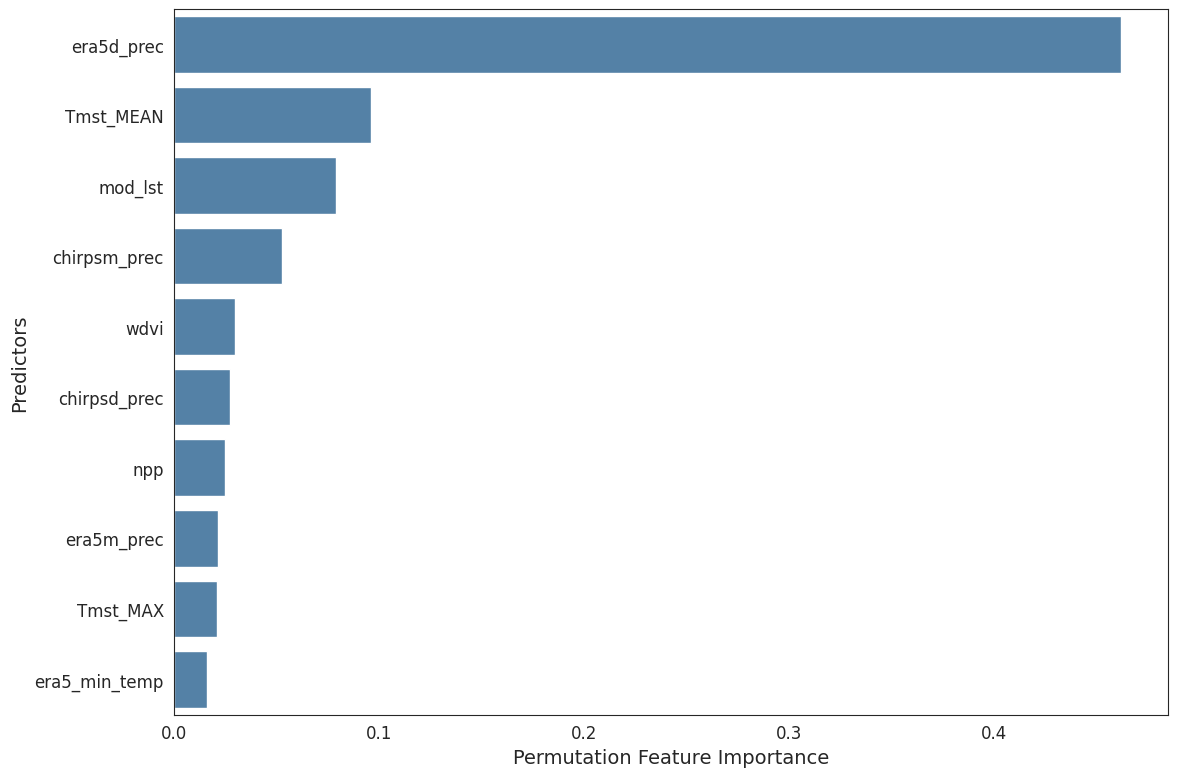

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'final_importances' DataFrame is already created

# Sort the DataFrame by test importance in descending order and select top 10
top_10_predictors = final_importances.sort_values(by=['test_importance'], ascending=False).head(10)
# top_10_predictors['renamed'] = ['daily ERA5 precipitation','CHIRTS maximum temperature','CHIRTS minimum temperature',
#                    'ERA5 maximum temperature','monthly ERA5 precipitation','CHIRTS mean temperature',
#                     'ERA5 minimum temperature','wdvi','evi','MODIS ndmi']

# Set white background before creating the plot
sns.set_style("white")

# Create the bar plot using Seaborn
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
sns.barplot(x='test_importance', y='predictor', data=top_10_predictors, color='steelblue')

# Customize the plot
# plt.title('Test Importance of Top 10 Predictors', fontsize=16)
plt.xlabel('Permutation Feature Importance', fontsize=14)
plt.ylabel('Predictors', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

**Feature Importance Computed with SHAP Values**

(it is model-agnostic) to compute the feature importances from the Random Forest. It is using the Shapley values from game theory to estimate the how does each feature contribute to the prediction.



In [87]:
!pip install shap

In [88]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(pred)

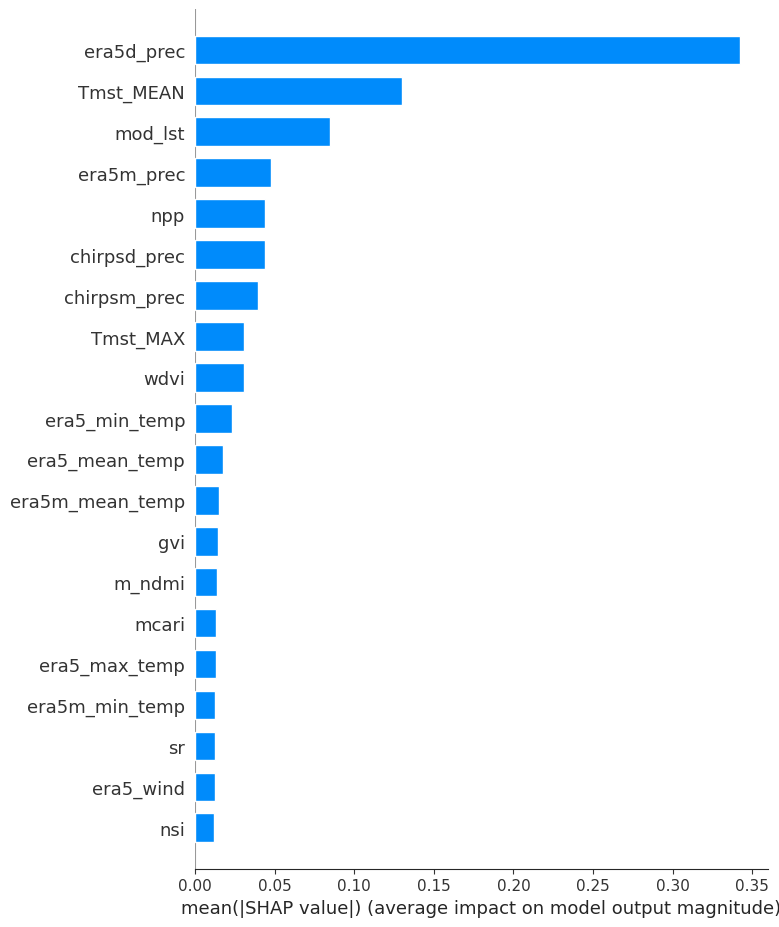

In [89]:
shap.summary_plot(shap_values, X_train, plot_type="bar")


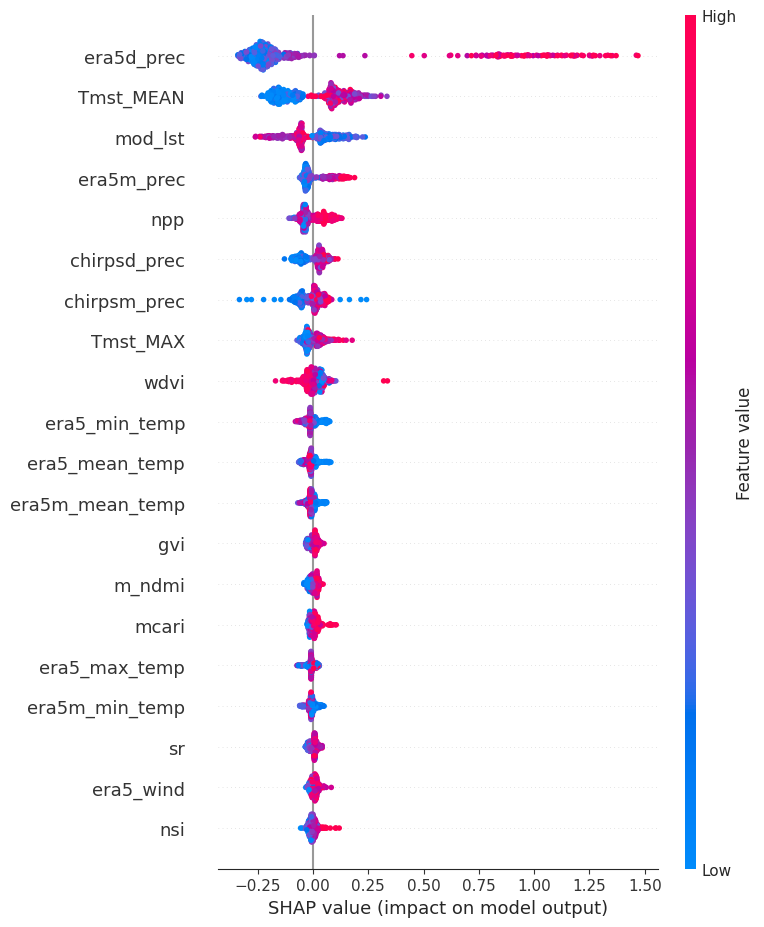

In [90]:
shap.summary_plot(shap_values, pred)

# 4.Pearson Correlation

## **4.1 Correlation Predictor Variables vs Yield**

### **4.1.1 Climate Predictor Variables vs Yield**

In [91]:
df.columns

Index(['key', 'COUNTY', 'Year', 'Yield', 'blue', 'green', 'red', 'nir',
       'swir1', 'swir2', 'ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi',
       'msavi', 'gci', 'gli', 'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2',
       'rdvi', 'gvi', 'ndii', 'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi',
       'pssra', 'dvi', 'era5d_prec', 'era5_wind', 'era5m_wind', 'era5m_prec',
       'era5_mean_temp', 'era5_min_temp', 'era5_max_temp', 'era5m_mean_temp',
       'era5m_min_temp', 'era5m_max_temp', 'chirpsd_prec', 'chirpsm_prec',
       'AREA', 'temp_MIN', 'temp_MAX', 'RANGE', 'temp_MEAN', 'temp_STD',
       'temp_SUM', 'fpar', 'm_lai', 'm_gndvi', 'm_ndvi', 'm_ndmi', 'gpp',
       'npp', 'Tmst_AREA', 'Tmst_MIN', 'Tmst_MAX', 'Tmst_RANGE', 'Tmst_MEAN',
       'Tmst_STD', 'Tmst_SUM', 'Yield2', 'mod_lst', 'ggcp10', 'final_Yld',
       'JoinedYld'],
      dtype='object')

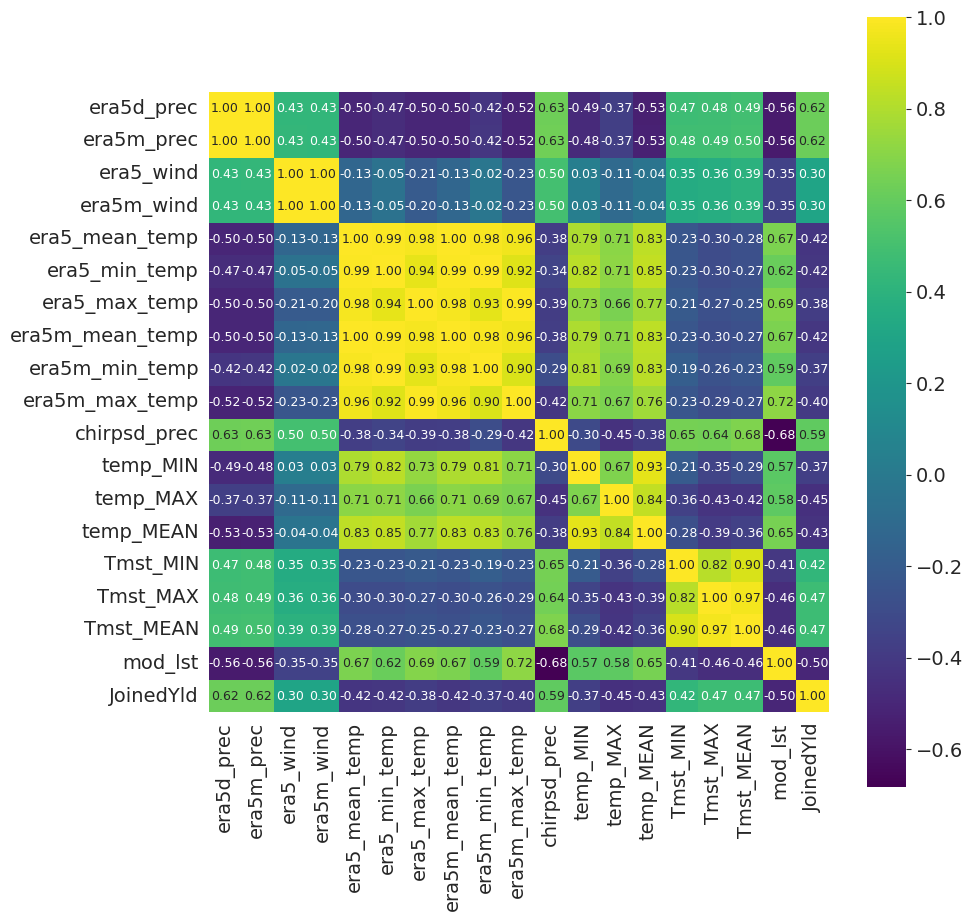

In [92]:
clim_var = [ 'era5d_prec','era5m_prec', 'era5_wind','era5m_wind','era5_mean_temp', 'era5_min_temp', 'era5_max_temp','era5m_mean_temp',
       'era5m_min_temp', 'era5m_max_temp','chirpsd_prec','temp_MIN', 'temp_MAX', 'temp_MEAN',  'Tmst_MIN','Tmst_MAX', 'Tmst_MEAN','mod_lst',
             'JoinedYld']

clim = pd.DataFrame(data, columns=clim_var)
fig = plt.figure(figsize=(10,10))

dataplot = sns.heatmap(clim.corr(),cmap="viridis", annot=True,fmt='.2f', annot_kws = {'size':9},
                       cbar_kws = dict(use_gridspec=False,location="right"),square=True)
# sns.set(font_scale=0.8)

order = feature_importance.groupby('Features').mean().sort_values('Importance',ascending=False).index

plt.show()

**Review the Correlation over the years.,,,**

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


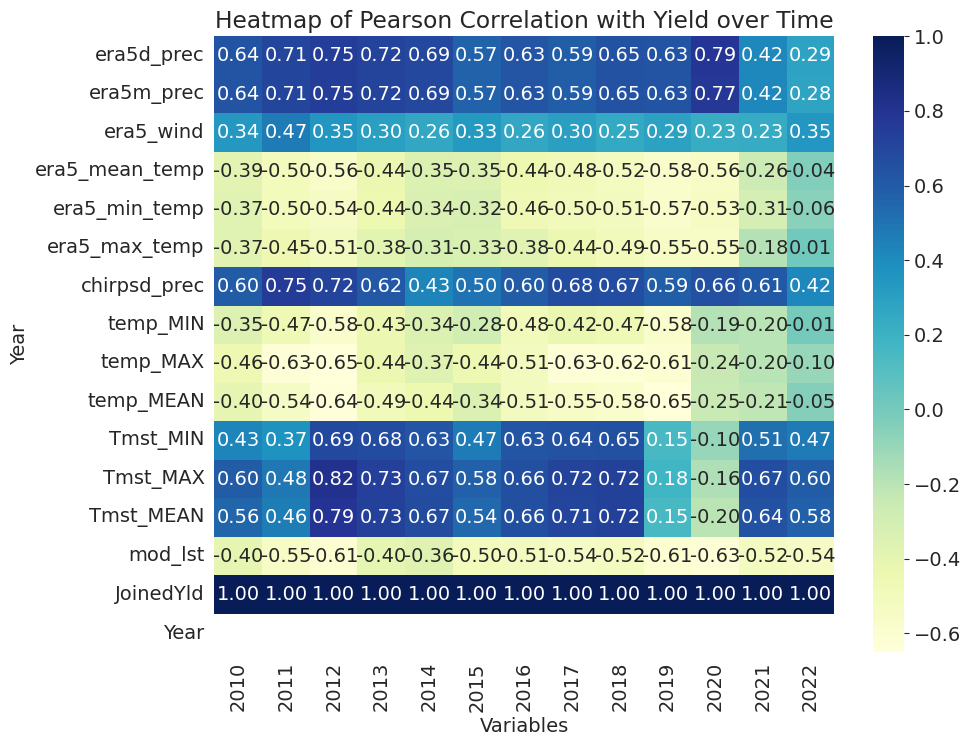

In [93]:
# Group data by year
clim_vars =  [ 'era5d_prec','era5m_prec', 'era5_wind','era5_mean_temp', 'era5_min_temp', 'era5_max_temp','chirpsd_prec',
            'temp_MIN', 'temp_MAX', 'temp_MEAN',  'Tmst_MIN','Tmst_MAX', 'Tmst_MEAN','mod_lst','JoinedYld','Year']
climy = pd.DataFrame(data, columns=clim_vars)
grouped = climy.groupby('Year')

# Create an empty dictionary to store correlation values
correlation_data = {}

# Iterate through each year's data
for year, group_data in grouped:
    # Calculate the Pearson correlation with 'Yield2' for each column
    correlations = group_data.corrwith(group_data['JoinedYld'])

    # Store correlations for the current year
    correlation_data[year] = correlations

# Create a DataFrame from the correlation data
heatmap_data = pd.DataFrame(correlation_data)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.xlabel("Variables")
plt.ylabel("Year")
plt.title("Heatmap of Pearson Correlation with Yield over Time")
plt.show()

### **4.1.2 MODIS Predictor Variables vs Yield**

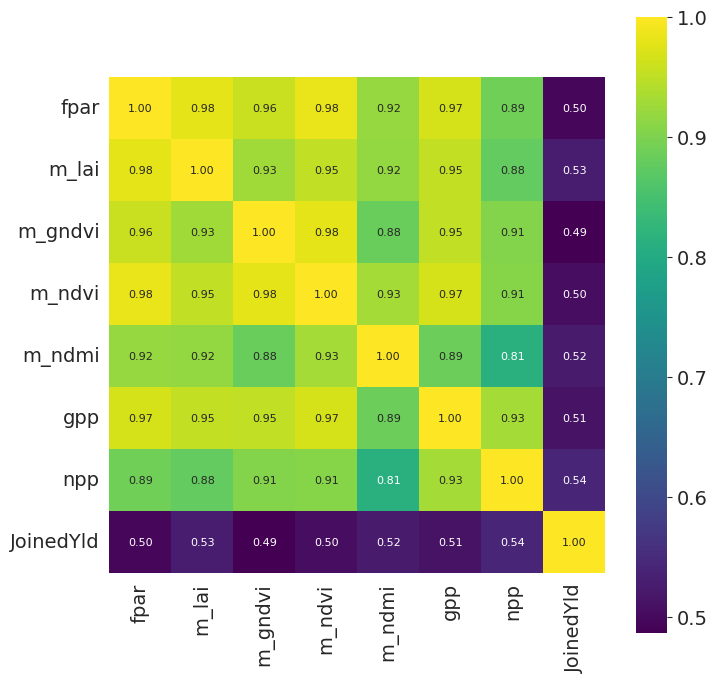

In [94]:
mod_var = ['fpar', 'm_lai', 'm_gndvi', 'm_ndvi', 'm_ndmi', 'gpp', 'npp','JoinedYld']
mod = pd.DataFrame(data, columns=mod_var)
fig = plt.figure(figsize=(8,8))

dataplot = sns.heatmap(mod.corr(),cmap="viridis", annot=True,fmt='.2f', annot_kws = {'size':8},
                       cbar_kws = dict(use_gridspec=False,location="right"),square=True)
plt.show()

**Review the Correlation over the years.,,,**

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


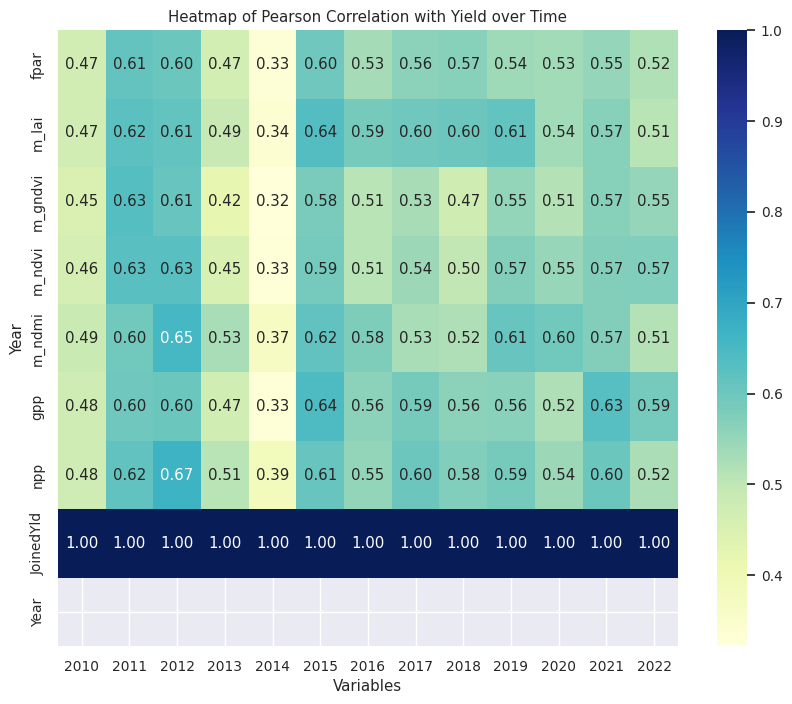

In [95]:
# Group data by year
mod_var_y = ['fpar', 'm_lai', 'm_gndvi', 'm_ndvi', 'm_ndmi', 'gpp','npp', 'JoinedYld','Year']
mod_y = pd.DataFrame(data, columns=mod_var_y)
grouped = mod_y.groupby('Year')

# Create an empty dictionary to store correlation values
correlation_data = {}

# Iterate through each year's data
for year, group_data in grouped:
    # Calculate the Pearson correlation with 'Yield' for each column
    correlations = group_data.corrwith(group_data['JoinedYld'])

    # Store correlations for the current year
    correlation_data[year] = correlations

# Create a DataFrame from the correlation data
heatmap_data = pd.DataFrame(correlation_data)
sns.set(font_scale=0.9)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.xlabel("Variables")
plt.ylabel("Year")
plt.title("Heatmap of Pearson Correlation with Yield over Time")
plt.show()

### **4.1.3 Landsat Indices Predictor Variables vs Yield**

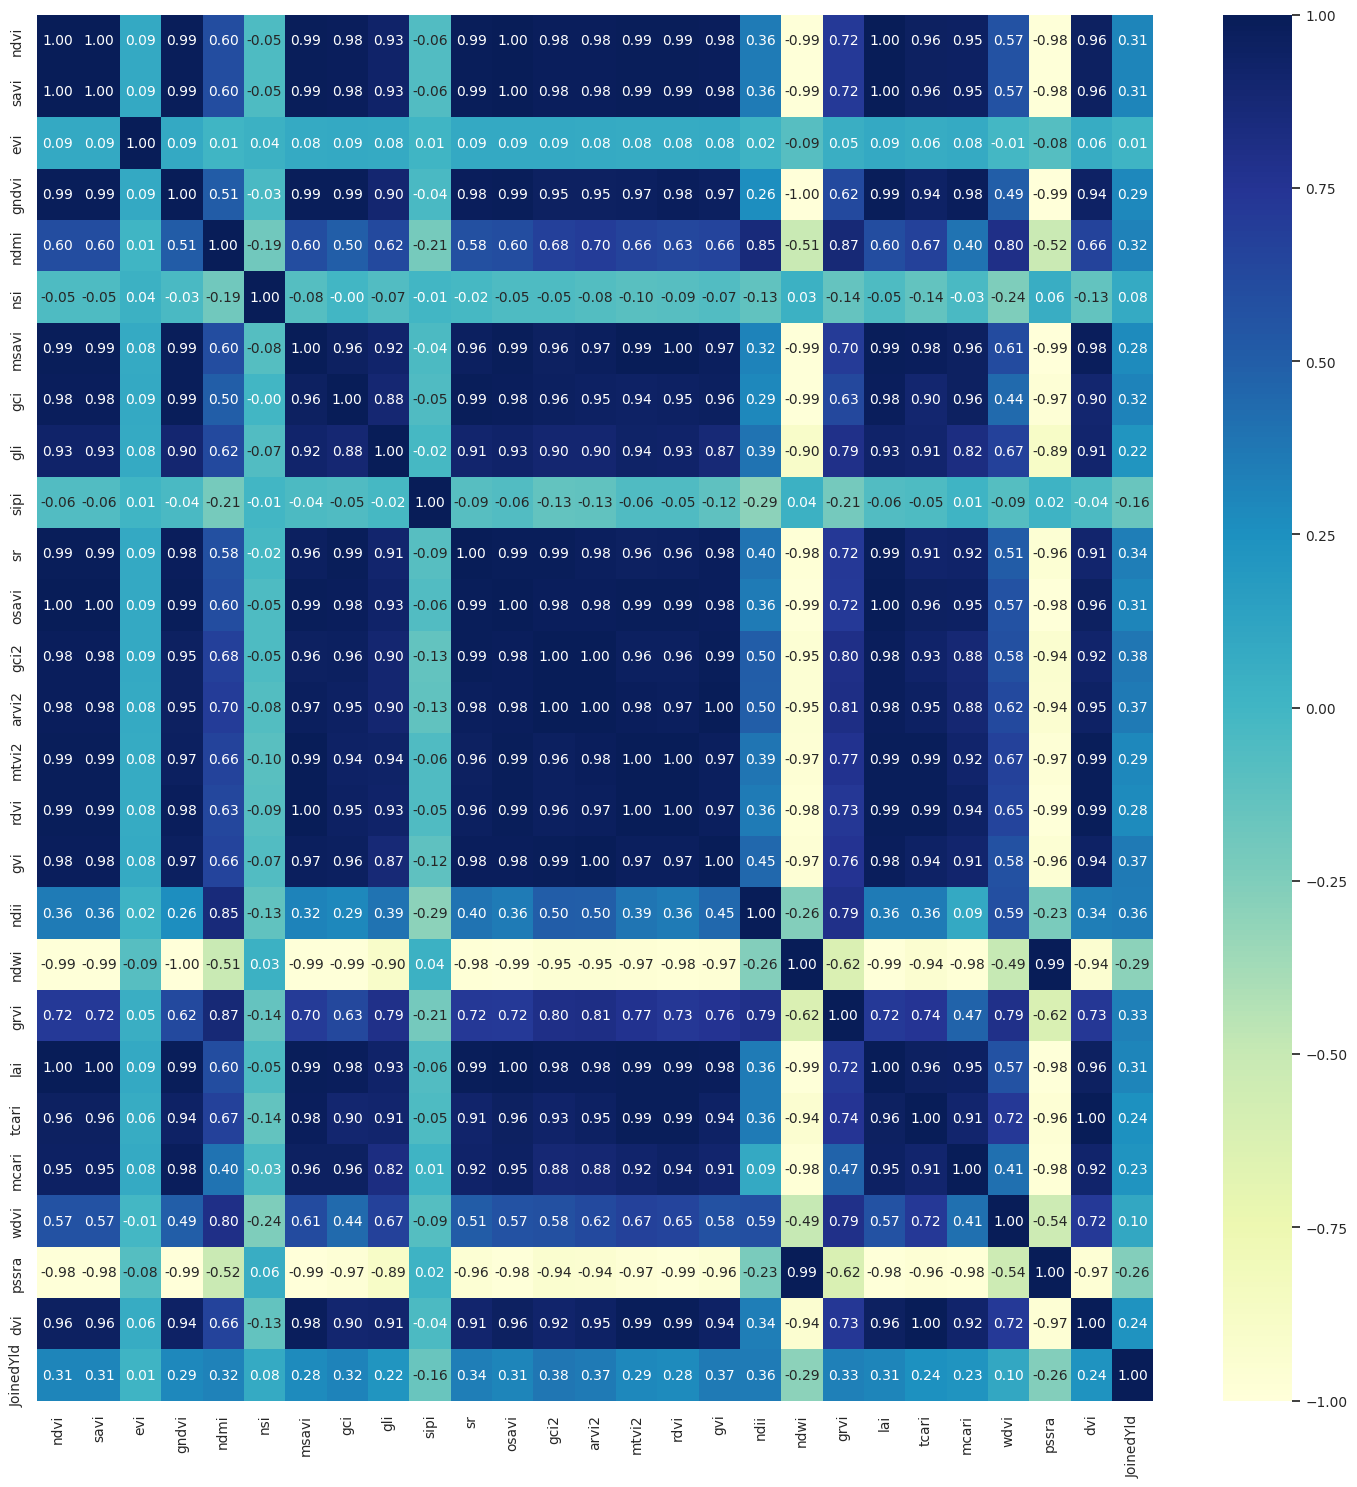

In [96]:
indx_var = ['ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi','msavi', 'gci', 'gli', 'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2',
            'rdvi', 'gvi', 'ndii', 'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi','pssra', 'dvi', 'JoinedYld']
indx = pd.DataFrame(data, columns=indx_var)
fig = plt.figure(figsize=(18,18))

dataplot = sns.heatmap(indx.corr(),cmap="YlGnBu", annot=True,fmt='.2f', annot_kws = {'size':10},
                       cbar_kws = dict(use_gridspec=False,location="right"),square=False)
sns.set(font_scale=2)
dataplot.set(xlabel="", ylabel="")

plt.show()

**Review the Correlation over the years.,,,**

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


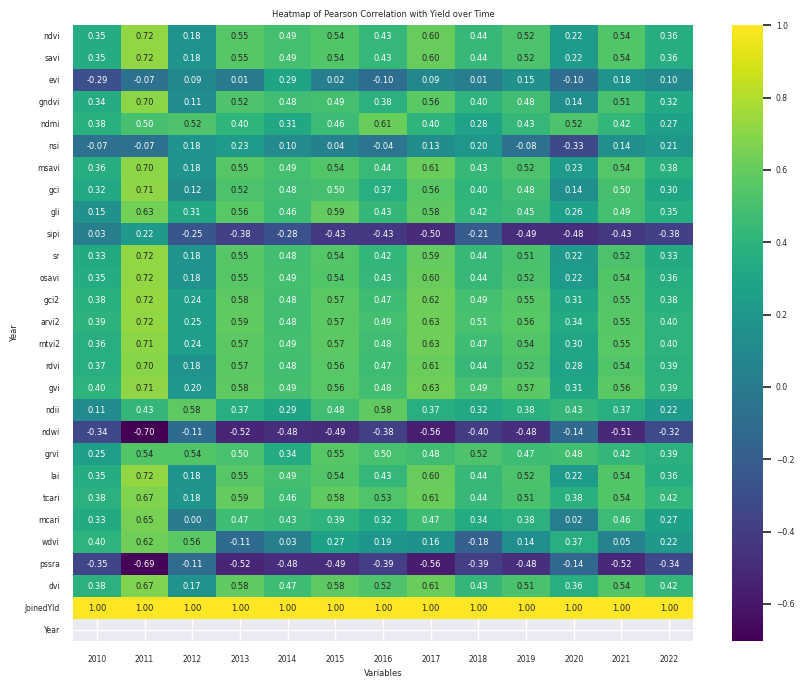

In [97]:
indx_var_y = ['ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi','msavi', 'gci', 'gli', 'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2',
       'rdvi', 'gvi', 'ndii', 'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi','pssra', 'dvi', 'JoinedYld', 'Year']
indx_y = pd.DataFrame(data, columns=indx_var_y)
# Group data by year
grouped = indx_y.groupby('Year')

# Create an empty dictionary to store correlation values
correlation_data = {}

# Iterate through each year's data
for year, group_data in grouped:
    # Calculate the Pearson correlation with 'Yield2' for each column
    correlations = group_data.corrwith(group_data['JoinedYld'])

    # Store correlations for the current year
    correlation_data[year] = correlations

# Create a DataFrame from the correlation data
heatmap_data = pd.DataFrame(correlation_data)
sns.set(font_scale=0.5)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis")
plt.xlabel("Variables")
plt.ylabel("Year")
plt.title("Heatmap of Pearson Correlation with Yield over Time")
plt.show()



```
TRAINING WITH SELECTED FEATURES
```
# **5. Random Forest Regressor Model Training**

In [101]:
new_data = pd.DataFrame(data=data)
new_data.columns
# 'sipi', 'gci', 'gli', 'ndmi','msavi', 'gndvi','Yield'
# 'evi', 'gci', 'gli', 'gndvi', 'msavi', 'ndmi', 'ndvi', 'nsi', 'savi','sipi'

Index(['key', 'COUNTY', 'Year', 'Yield', 'blue', 'green', 'red', 'nir',
       'swir1', 'swir2', 'ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi',
       'msavi', 'gci', 'gli', 'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2',
       'rdvi', 'gvi', 'ndii', 'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi',
       'pssra', 'dvi', 'era5d_prec', 'era5_wind', 'era5m_wind', 'era5m_prec',
       'era5_mean_temp', 'era5_min_temp', 'era5_max_temp', 'era5m_mean_temp',
       'era5m_min_temp', 'era5m_max_temp', 'chirpsd_prec', 'chirpsm_prec',
       'AREA', 'temp_MIN', 'temp_MAX', 'RANGE', 'temp_MEAN', 'temp_STD',
       'temp_SUM', 'fpar', 'm_lai', 'm_gndvi', 'm_ndvi', 'm_ndmi', 'gpp',
       'npp', 'Tmst_AREA', 'Tmst_MIN', 'Tmst_MAX', 'Tmst_RANGE', 'Tmst_MEAN',
       'Tmst_STD', 'Tmst_SUM', 'Yield2', 'mod_lst', 'ggcp10', 'final_Yld',
       'JoinedYld'],
      dtype='object')

In [102]:
features= new_data

**Select the Selected features**

In [103]:
# TRAIN SPLIT
yld = new_data['JoinedYld']
pred = new_data[['era5d_prec', 'temp_MAX', 'era5m_prec','era5m_max_temp', 'temp_MIN',  'wdvi','era5_min_temp', 'm_ndmi', 'era5_wind', 'evi', 'chirpsm_prec', 'mod_lst']]

In [104]:
pred.columns

Index(['era5d_prec', 'temp_MAX', 'era5m_prec', 'era5m_max_temp', 'temp_MIN',
       'wdvi', 'era5_min_temp', 'm_ndmi', 'era5_wind', 'evi', 'chirpsm_prec',
       'mod_lst'],
      dtype='object')

In [105]:
# y_train.shape

In [106]:
# RF Regressor & Fit
# create a classifier and fit
n_trees = 200
clf = RandomForestRegressor(n_trees,random_state = 42)
clf.fit(pred,yld)

RandomForestRegressor(n_estimators=200, random_state=42)

In [107]:
feature_name=pred.columns
feature_name

Index(['era5d_prec', 'temp_MAX', 'era5m_prec', 'era5m_max_temp', 'temp_MIN',
       'wdvi', 'era5_min_temp', 'm_ndmi', 'era5_wind', 'evi', 'chirpsm_prec',
       'mod_lst'],
      dtype='object')



```
# Leave One Year Out Cross Validation
```

# **6. Leave One Year Out Cross Validation**

In [108]:
logo = LeaveOneGroupOut()

In [109]:
group = data['Year']

In [110]:
logo.get_n_splits(groups=group)

13

**Validation Metrics:**
1. cross_val_score : Calculate score for each CV split.
2. cross_validate : Calculate one or more scores and timings for each CV split. To run cross-validation on multiple metrics and also to return
3. cross_val_predict : Get predictions from each split of cross-validation for diagnostic purposes.
4. make_scorer : Make a scorer from a performance metric or loss function

In [111]:
from sklearn.model_selection import cross_validate,cross_val_predict,permutation_test_score
from sklearn.metrics import make_scorer

In [112]:
scores = cross_val_score(clf,pred,yld,groups=group,scoring='neg_mean_squared_error',cv=logo,n_jobs=-1)


### **6.1. Cross Validation**
Run cross-validation on R2, MSE, RMSE, MAPE metrics and also to return train scores, fit times and score times


In [113]:
cross_validate_results = cross_validate(clf,pred,yld,groups=group,
                                        scoring=('r2', 'neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_percentage_error'),
                                        return_train_score=True,cv=logo,n_jobs=-1)

In [114]:
cross_validate_results.keys()


dict_keys(['fit_time', 'score_time', 'test_r2', 'train_r2', 'test_neg_mean_squared_error', 'train_neg_mean_squared_error', 'test_neg_root_mean_squared_error', 'train_neg_root_mean_squared_error', 'test_neg_mean_absolute_percentage_error', 'train_neg_mean_absolute_percentage_error'])

In [115]:
metrics = pd.DataFrame(cross_validate_results, columns = ['train_r2','test_r2',
                                                          'train_neg_mean_squared_error','test_neg_mean_squared_error',
                                                          'train_neg_root_mean_squared_error','test_neg_root_mean_squared_error',
                                                          'train_neg_mean_absolute_percentage_error','test_neg_mean_absolute_percentage_error'])
years = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]
metrics['Year'] = years
metrics

ValueError: Length of values (11) does not match length of index (13)

#### **6.1.1 Plot Train and Test Validation Metrics (R2, RMSE, MSE, MAPE)**

In [ ]:
fig = plt.figure()
sns.set(font_scale=1)
ax1 = plt.subplot(2,2,1)

plt.plot(metrics['Year'],metrics['train_r2'],label='train')
plt.plot(metrics['Year'],metrics['test_r2'],label='test')
# ax1.title.set_text('R^2')
ax1.legend()
ax1.set_ylabel('R^2', fontsize=15)
# ax1.set_xlabel('Year', fontsize=15)

ax2 = plt.subplot(2,2,2)
plt.plot(metrics['Year'],(metrics['train_neg_mean_squared_error']*-1),label='train')
plt.plot(metrics['Year'],(metrics['test_neg_mean_squared_error']*-1),label='test')
# ax2.title.set_text('MSE')
ax2.legend()
ax2.set_ylabel('MSE', fontsize=15)
# ax2.set_xlabel('Year', fontsize=15)

ax3 = plt.subplot(2,2,3)
plt.plot(metrics['Year'],(metrics['train_neg_root_mean_squared_error']*-1),label='train')
plt.plot(metrics['Year'],(metrics['test_neg_root_mean_squared_error']*-1),label='test')
# ax3.title.set_text('RMSE')
ax3.set_ylabel('RMSE', fontsize=15)
ax3.set_xlabel('Year', fontsize=15)
ax3.legend()

ax4 = plt.subplot(2,2,4)
plt.plot(metrics['Year'],(metrics['train_neg_mean_absolute_percentage_error']*-1),label='train')
plt.plot(metrics['Year'],(metrics['test_neg_mean_absolute_percentage_error']*-1),label='test')
# ax2.title.set_text('MSE')
ax4.legend()
ax4.set_ylabel('MAPE', fontsize=15)
ax4.set_xlabel('Year', fontsize=15)

# Labels to use in the legend for each line
labels = ["Train", "Test"]

fig.tight_layout()
# fig.legend([ax3, ax3], labels=labels,loc="upper right")


### **6.2 Make predictions based on the new classifier**

In [138]:
from numpy import mean
from numpy import absolute
from numpy import sqrt
from sklearn.metrics import r2_score

In [ ]:
# Get predictions from each split of cross-validation for diagnostic purposes
cross_val_prediction = cross_val_predict(clf,pred,yld,groups=group,cv=logo,n_jobs=-1,)

In [ ]:
# cross_val_prediction.size


In [ ]:
# Evaluate the significance of a cross-validated score with permutations.
#score,permutation_test_scores,pvalue = permutation_test_score(clf,pred,yld,groups=group,cv=logo,n_jobs=-1)

Join the predictions with the data

In [ ]:
data['predictions'] = cross_val_prediction
data.describe()

#### **6.2.1 Predicted vs. actual Variables plot**

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(data['JoinedYld'], data['predictions'], c='crimson')
# plt.yscale('log')
# plt.xscale('log')
y_test = data['JoinedYld']
y_predicted = data['predictions']
p1 = max(max(data['predictions']), max(data['JoinedYld']))
p2 = min(min(data['predictions']), min(data['JoinedYld']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Yield (mt/ha)', fontsize=15)
plt.ylabel('Predicted Yield (mt/ha)', fontsize=15)
plt.axis('equal')
plt.annotate("R-squared = {:.3f}".format(r2_score(y_test, y_predicted)), (0, 4))
plt.show()

# **7. Export and Save the Classifier**

- You can skip this step.

In [ ]:
# convert the estimator into a list of strings
# this function also works with the ensemble.ExtraTrees estimator
# trees = ml.rf_to_strings(clf,feature_name,2,"REGRESSION")

In [ ]:
# number of trees we converted should equal the number of trees we defined for the model
# len(trees) == n_trees

In [ ]:
# create a ee classifier to use with ee objects from the trees
# ee_classifier = ml.strings_to_classifier(trees)

In [ ]:
# ee_classifier.getInfo()

In [ ]:
# joblib.dump(clf, "./random_forest.joblib")

In [ ]:
# ee_serialized = ee_classifier.serialize()

In [ ]:
# user_id = geemap.ee_user_id()
# user_id

# # specify asset id where to save trees
# # be sure to change  to your ee user name
# asset_id = user_id + "/random_forest_"
# asset_id


In [ ]:
# kick off an export process so it will be saved to the ee asset
# ml.export_trees_to_fc(trees, asset_id)
#
# this will kick off an export task, so wait a few minutes before moving on

In [ ]:
# # read the exported tree feature collection
# rf_fc = ee.FeatureCollection(asset_id)

# # # convert it to a classifier, very similar to the `ml.trees_to_classifier` function
# another_classifier = ml.fc_to_classifier(rf_fc)

# # # classify the image again but with the classifier from the persisted trees
# classified = image.select(feature_names).classify(another_classifier)

In [ ]:
# import os

# out_csv = os.path.expanduser("/content/drive/MyDrive/trees.csv")

In [ ]:
# ml.trees_to_csv(trees, out_csv)

In [ ]:
# another_classifier = ml.csv_to_classifier(out_csv)

In [ ]:
# classified = image.select(feature_names).classify(another_classifier)

In [ ]:
# task = ee.batch.Export.table.toAsset(**{
#     'collection'=encodeFeatureCollection(decisionTrees),
#     'description'='export_classifier',
#     'assetId'='users/Prod/ee_classifier',
# })
# task.start()

# **8. TESTING WITH 2021-2022 DATA**

Extract 2021 and 2022 data

In [132]:
test21_22 = df[df['Year'].between(2021, 2022)]
test21_22

,key,COUNTY,Year,Yield,blue,green,red,nir,swir1,swir2,...,Tmst_MAX,Tmst_RANGE,Tmst_MEAN,Tmst_STD,Tmst_SUM,Yield2,mod_lst,ggcp10,final_Yld,JoinedYld
461,2021_BARINGO,BARINGO,2021,NaN,11460.898160,12608.92418,12767.00062,18531.36454,16179.79557,13680.72272,...,247.800003,154.200005,160.355932,41.961498,28382.999920,1.70,15095.44521,NaN,1.704726,1.704726
462,2021_BOMET,BOMET,2021,NaN,9326.657492,10715.91775,10443.58105,19385.59656,15527.53833,12343.67468,...,210.199997,107.500000,154.028071,24.544730,8779.600021,1.45,14928.34416,NaN,1.704726,1.704726
463,2021_BUNGOMA,BUNGOMA,2021,NaN,12602.566820,13714.83854,13540.80900,21093.64886,16551.06540,13644.29079,...,209.600006,76.700012,166.999999,17.446569,22878.999890,2.89,14967.61093,NaN,1.704726,1.704726
464,2021_BUSIA,BUSIA,2021,NaN,10622.750650,12029.86649,11925.33456,19882.61603,16348.67698,13358.70258,...,188.100006,57.700012,160.351853,14.128014,12988.500080,1.24,15078.83896,NaN,1.243064,1.243064
465,2021_ELGEYO-MARAKWET,ELGEYO-MARAKWET,2021,NaN,14092.756490,15062.52645,15072.34865,21431.18750,17253.12189,14392.27486,...,232.899994,129.399994,168.205455,33.262856,9251.300011,2.74,14847.02643,NaN,2.743357,2.743357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,2022_TRANS NZOIA,TRANS NZOIA,2022,NaN,13280.046530,14416.41360,14387.53534,21319.92801,16868.91258,14168.32388,...,158.500000,77.099998,118.168142,16.064765,13353.000050,NaN,14960.55193,NaN,3.573576,3.573576
539,2022_TURKANA,TURKANA,2022,NaN,11081.265230,12701.43966,13370.20804,19215.70020,16788.13028,14694.39021,...,0.600000,0.000000,0.600000,0.000000,0.600000,NaN,15787.10061,NaN,0.132482,0.132482
540,2022_UASIN GISHU,UASIN GISHU,2022,NaN,15924.236490,16793.24959,16900.12788,22514.50984,18307.82148,15405.13307,...,155.100006,79.300003,104.667683,17.023466,17165.499950,NaN,14891.12617,NaN,3.500000,3.500000
541,2022_VIHIGA,VIHIGA,2022,NaN,10899.808670,12243.34086,12113.23125,20331.52333,15659.46462,12856.96251,...,220.199997,53.500000,189.724137,12.211233,5501.999985,NaN,14929.61504,NaN,0.969130,0.969130


In [133]:
testdf = test21_22[['era5d_prec', 'temp_MAX', 'era5m_prec','era5m_max_temp', 'temp_MIN',  'wdvi','era5_min_temp', 'm_ndmi', 'era5_wind', 'evi', 'chirpsm_prec', 'mod_lst']]
testdf

,era5d_prec,temp_MAX,era5m_prec,era5m_max_temp,temp_MIN,wdvi,era5_min_temp,m_ndmi,era5_wind,evi,chirpsm_prec,mod_lst
461,0.007518,31.938599,0.230155,301.254753,20.238519,12147.86424,288.656887,0.087983,-0.299053,1.784001,22.909437,15095.44521
462,0.004619,25.965830,0.142757,298.805258,21.916509,14163.80606,286.802469,0.161588,-1.188601,1.877671,23.732274,14928.34416
463,0.011963,29.982564,0.368024,298.162482,22.469358,14323.24436,287.453198,0.186639,-0.261648,2.557420,33.603505,14967.61093
464,0.006809,30.161824,0.210320,302.138288,28.635179,13919.94874,291.236583,0.141153,-0.107021,1.749971,33.252457,15078.83896
465,0.020667,30.615132,0.631211,297.521671,19.262981,13895.01320,286.179631,0.156446,-0.240836,3.455338,26.392680,14847.02643
...,...,...,...,...,...,...,...,...,...,...,...,...
538,0.003577,35.909781,0.105212,301.818151,28.409985,14126.16034,290.746945,0.199905,-0.690943,3.544773,4.186121,14960.55193
539,0.010982,26.444695,0.342975,297.896131,21.775780,12530.59622,286.951076,-0.021080,-0.598598,1.003145,0.652969,15787.10061
540,0.003721,34.401841,0.112294,307.303309,34.401841,14064.44591,295.115950,0.155621,-0.584549,2.852756,3.949027,14891.12617
541,0.010243,26.659979,0.321295,298.012243,20.808950,14274.90774,286.445862,0.231280,-0.231377,1.911246,6.286040,14929.61504


In [134]:
predictions = clf.predict(testdf)
predictions

array([1.64588546, 1.70030847, 1.69858151, 1.37238616, 2.913817  ,
       0.88660591, 0.60820864, 0.91611954, 0.70152893, 2.4983329 ,
       2.82007953, 0.97237369, 0.56628552, 0.903344  , 1.57603201,
       0.9609924 , 0.25220923, 0.73326683, 1.40654121, 0.72309685,
       0.53264589, 0.61665892, 0.23295767, 0.83440293, 1.15041259,
       0.82850734, 2.66305121, 2.37346832, 2.18470061, 1.51677928,
       1.795149  , 0.72110161, 0.88261514, 0.54121751, 0.47285409,
       1.06042492, 3.44773951, 1.09692699, 3.20406784, 1.73139954,
       1.50952565, 1.50684981, 1.51248964, 1.58273338, 1.48055226,
       2.35175095, 0.52786727, 0.69750872, 0.81114169, 0.55293713,
       1.65245017, 2.22787538, 0.80791186, 0.70959207, 0.81967415,
       1.7513191 , 1.58633643, 0.20280808, 1.48770512, 1.7527579 ,
       1.50493927, 0.35695054, 0.64154536, 0.13681157, 0.90721404,
       1.17394011, 0.78524548, 2.64926813, 1.97057743, 1.95851603,
       1.61344182, 1.45295298, 0.6261832 , 1.03598067, 0.96744

In [140]:
test21_22['predictions_21_22'] = predictions
test21_22.describe()

<ipython-input-140-c5c2698247ac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test21_22['predictions_21_22'] = predictions


,Year,Yield,blue,green,red,nir,swir1,swir2,ndvi,savi,...,Tmst_MEAN,Tmst_STD,Tmst_SUM,Yield2,mod_lst,ggcp10,final_Yld,JoinedYld,predictions,predictions_21_22
count,82.000000,0.0,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,...,82.000000,82.000000,82.000000,41.000000,82.000000,0.0,82.000000,82.000000,82.000000,82.000000
mean,2021.500000,NaN,14765.271511,15725.451178,15866.540249,21671.653423,18046.556187,14983.811341,0.164799,0.247195,...,82.371365,16.226271,7879.057314,1.322439,15065.755443,NaN,1.292627,1.292627,1.329345,1.329345
std,0.503077,NaN,3469.738019,3186.425647,3293.517180,2215.985925,1937.572976,1686.304989,0.061077,0.091614,...,74.939208,14.106116,9387.160939,0.978240,202.849151,NaN,0.904035,0.904035,0.768583,0.768583
min,2021.000000,NaN,9326.657492,10715.917750,10443.581050,16626.142070,14864.490680,11999.338790,0.023438,0.035157,...,0.000000,0.000000,0.000000,0.070000,14795.758380,NaN,0.005076,0.005076,0.136812,0.136812
25%,2021.000000,NaN,12401.303150,13486.532955,13393.553322,20211.263872,16355.025640,13612.732068,0.117131,0.175694,...,1.708764,3.904075,176.025001,0.640000,14917.482878,NaN,0.654352,0.654352,0.725639,0.725639
50%,2021.500000,NaN,14133.598190,15219.920265,15414.468160,21196.462520,17704.080900,14731.975825,0.153757,0.230632,...,106.076366,15.509195,5660.049995,1.030000,15023.533790,NaN,1.063794,1.063794,1.130799,1.130799
75%,2022.000000,NaN,16707.132667,17462.968818,17635.395463,22773.378630,19642.448740,16350.326160,0.213381,0.320066,...,154.607944,24.638792,13009.650027,1.700000,15183.361675,NaN,1.704726,1.704726,1.687049,1.687049
max,2022.000000,NaN,25959.321930,25967.790430,26557.339920,27759.740530,22320.711770,18414.983600,0.300921,0.451374,...,208.531035,63.488917,41791.999920,3.900000,15829.651970,NaN,3.901531,3.901531,3.447740,3.447740


In [141]:
yieldtest = test21_22['JoinedYld']


In [142]:
r2_score(yieldtest,predictions )
print('R-squared:', round(100 * (r2_score(yieldtest,predictions )), 2), '%.')

R-squared: 94.24 %.


In [156]:
from sklearn.metrics import mean_squared_error
import math
y_actual = yieldtest
y_predicted = predictions

MSE = mean_squared_error(y_actual, y_predicted)

RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

0.21560813715433305


# **9.Testing  Field dataaset**

In [155]:
field_data = pd.read_csv('/data/field_data.csv')
field_data_pred =

,type,ident,Latitude,Longitude,y_proj,x_proj,Area,Area_Acr,Sub_Coun_1,Crop_2022,Qty_tons,Area_ha,yield_t_ha,bgstokgs
0,TRACK,75.0,0.870851,35.406914,0.870851,35.406914,547.047,0.0,Moiben,Maize,2.70,0.648,4.167,2700.0
1,TRACK,76.0,0.876440,35.410660,0.876440,35.410660,35949.584,9.0,Moiben,Maize,9.00,4.047,2.224,9000.0
2,TRACK,77.0,0.879031,35.412072,0.879031,35.412072,29135.751,7.0,Moiben,Maize,0.90,6.070,0.148,900.0
3,TRACK,78.0,0.889607,35.416854,0.889607,35.416854,55643.031,14.0,Moiben,Maize,2.25,16.188,0.139,2250.0
4,TRACK,79.0,0.894144,35.420769,0.894144,35.420769,9307.509,2.0,Moiben,Maize,7.20,0.809,8.900,7200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,TRACK,292.0,0.712704,35.273122,0.712704,35.273122,44798.721,11.0,Soy,Maize,1.98,2.833,0.699,1980.0
220,TRACK,293.0,0.711266,35.284301,0.711266,35.284301,131.764,0.0,Soy,Maize,1.71,0.809,2.114,1710.0
221,TRACK,294.0,0.701370,35.292502,0.701370,35.292502,13826.653,3.0,Soy,Maize,1.80,0.607,2.965,1800.0
222,TRACK,295.0,0.698094,35.295287,0.698094,35.295287,407282.662,101.0,Soy,Maize,1.98,7.285,0.272,1980.0


In [151]:
field_data_pred

,arvi2,era5_min_temp,gli,gpp,wdvi,chirpsd_prec,gvi,npp,era5d_prec,Year,Yield_n
0,NaN,289.955872,NaN,36511.000000,NaN,4.225003,NaN,23370.000000,0.011687,2010,NaN
1,0.154516,289.851509,-0.001419,22725.175369,12829.910118,4.074952,0.083018,13888.322596,0.012062,2010,NaN
2,0.171184,289.537140,-0.002382,19994.000000,12669.833008,4.086236,0.099593,12581.000000,0.012703,2010,NaN
3,0.123822,288.947398,0.011106,13479.943396,11084.258122,4.233857,0.068001,8960.000000,0.010580,2010,NaN
4,NaN,287.157745,NaN,16728.000000,NaN,4.018706,NaN,11381.000000,0.007126,2010,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3226,NaN,297.802734,NaN,10347.000000,NaN,2.284055,NaN,5742.000000,0.001635,2011,NaN
3227,0.165987,287.117196,0.012701,20352.980763,11584.217634,4.148416,0.086925,12863.878500,0.006882,2011,NaN
3228,NaN,285.449463,NaN,28112.000000,NaN,3.475556,NaN,19600.000000,0.005445,2011,NaN
3229,NaN,286.034180,NaN,9962.000000,NaN,3.354603,NaN,6912.000000,0.005062,2011,NaN


In [153]:
predictions = clf.predict(field_data_pred)
field_data['field_data'] = predictions
field_data.describe()

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- arvi2
- chirpsd_prec
- gli
- gpp
- gvi
- ...
Feature names seen at fit time, yet now missing:
- chirpsm_prec
- era5_wind
- era5m_max_temp
- era5m_prec
- evi
- ...


In [ ]:
#  Calculate the absolute errors
errors = abs(field_data['field_data'] - field_data['yield_t_ha'])
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / field_data['yield_t_ha'])
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
print('MAPE:', round(np.mean(mape), 2), '%.')


In [ ]:
field_data[field_data.isna().any(axis=1)]

In [ ]:
field_data = field_data[field_data['yield_t_ha'].notna()]

In [ ]:
y_test = field_data['yield_t_ha']
y_predicted = field_data['field_data']
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_predicted, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(y_predicted), max(y_test))
p2 = min(min(y_predicted), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Yield (mt/ha)', fontsize=15)
plt.ylabel('Predicted Yield (mt/ha)', fontsize=15)
plt.axis('equal')
plt.annotate("R-squared = {:.3f}".format(r2_score(y_test, y_predicted)), (0, 9))
plt.show()

In [ ]:
field_data=field_data[field_data['field_data'] > 0]

y_true = field_data['yield_t_ha']
y_pred = field_data['field_data']
mape = mean_absolute_percentage_error(y_true, y_pred)
mse =  mean_squared_error(y_true, y_pred)
rmse =  mean_squared_error(y_true, y_pred,squared=False)
r2 =  r2_score(y_true, y_pred)
test_dict = {'index':[0],'MAPE': mape,'MSE':mse,'RMSE':rmse,'r2':r2}
test_metrics = pd.DataFrame(data=test_dict)
test_metrics

# **10.Testing  With New Zones definition**

In [160]:
test_new_zones = pd.read_csv('/content/test_merged_new_zones.csv')
test_new_zones

,arvi2,era5_min_temp,gli,gpp,wdvi,chirpsd_prec,gvi,npp,era5d_prec,Year,Yield_n
0,NaN,289.955872,NaN,36511.000000,NaN,4.225003,NaN,23370.000000,0.011687,2010,NaN
1,0.154516,289.851509,-0.001419,22725.175369,12829.910118,4.074952,0.083018,13888.322596,0.012062,2010,NaN
2,0.171184,289.537140,-0.002382,19994.000000,12669.833008,4.086236,0.099593,12581.000000,0.012703,2010,NaN
3,0.123822,288.947398,0.011106,13479.943396,11084.258122,4.233857,0.068001,8960.000000,0.010580,2010,NaN
4,NaN,287.157745,NaN,16728.000000,NaN,4.018706,NaN,11381.000000,0.007126,2010,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3226,NaN,297.802734,NaN,10347.000000,NaN,2.284055,NaN,5742.000000,0.001635,2011,NaN
3227,0.165987,287.117196,0.012701,20352.980763,11584.217634,4.148416,0.086925,12863.878500,0.006882,2011,NaN
3228,NaN,285.449463,NaN,28112.000000,NaN,3.475556,NaN,19600.000000,0.005445,2011,NaN
3229,NaN,286.034180,NaN,9962.000000,NaN,3.354603,NaN,6912.000000,0.005062,2011,NaN


In [ ]:
predictions = clf.predict(test_new_zones_pred)
test_new_zones['new_zone'] = predictions
test_new_zones.describe()

In [ ]:
#  Calculate the absolute errors
errors = abs(test_new_zones_pred['new_zone'] - test_new_zones_pred['Yield_n'])
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

In [ ]:
#view RMSE
print('RMSE:', round(sqrt(mean(absolute(scores))), 2))

In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_new_zones_pred['Yield_n'])
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
print('MAPE:', round(np.mean(mape), 2), '%.')


In [ ]:
test_new_zones_pred[test_new_zones_pred.isna().any(axis=1)]

In [ ]:
test_new_zones_pred = test_new_zones_pred[test_new_zones_pred['new_zone'].notna()]

In [ ]:
y_test = test_new_zones_pred['Yield_n']
y_predicted = test_new_zones_pred['new_zone']
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_predicted, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(y_predicted), max(y_test))
p2 = min(min(y_predicted), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Yield (mt/ha)', fontsize=15)
plt.ylabel('Predicted Yield (mt/ha)', fontsize=15)
plt.axis('equal')
plt.annotate("R-squared = {:.3f}".format(r2_score(y_test, y_predicted)), (0, 9))
plt.show()

In [ ]:
test_new_zones_pred=test_new_zones_pred[test_new_zones_pred['new_zone'] > 0]

y_true = test_new_zones_pred['Yield_n']
y_pred = test_new_zones_pred['new_zone']
mape = mean_absolute_percentage_error(y_true, y_pred)
mse =  mean_squared_error(y_true, y_pred)
rmse =  mean_squared_error(y_true, y_pred,squared=False)
r2 =  r2_score(y_true, y_pred)
test_dict = {'index':[0],'MAPE': mape,'MSE':mse,'RMSE':rmse,'r2':r2}
test_metrics = pd.DataFrame(data=test_dict)
test_metrics